# IN-CORE Flowchart - Seaside
This notebook uses the Seaside testbed to demonstrate the following components of the IN-CORE flowchart. 
+ [Start](#0)
+ [1. Initial Community Description](#1)
  + [1a. Built Environment](#1a)
  + [1b. Social Systems](#1b)
  + [1c. Economic Systems](#1c)
+ [2. Hazards and Damages](#2)
  + [2a. Hazard Models](#2a)
  + [2b. Damage Models](#2b)
  + [2c. Damage to Physical Infrastructure](#2c)
+ [3. Functionality](#3)
  + [3a. Functionality Models](#3a)
  + [3b. Functionality of Physical Infrastructure](#3b)
  + [3c. CGE Model](#3c)
  + [3d. Social Science Modules](#3d)
  + [3e. Direct and Indirect Economic & Social Losses](#3e)
+ [4. Recovery](#4)
+ [References](#ref)


<!-- *Notebook created by Dylan R. Sanderson (OSU - sanderdy@oregonstate.edu) -->

![title](images/Flowchart_0.png)<br>

***
## Background

The North American Pacific Northwest is subject to the rupture of the Cascadia Subduction Zone (CSZ), which is an approximately 1,000 km long fault located between Cape Mendocino California and Vancouver Island, Canada, and separates the Juan de Fuca and North America plates. Rupture of the CSZ can result in both strong earthquake ground shaking and tsunami inundation. The last full rupture of the CSZ occurred in 1700 and is estimated to have had a moment magnitude between 8.7 and 9.2. The city of Seaside is a small coastal town located along the northern Oregon coast, and has a full-time population of approximately 6,700 people. As a popular coastal town, Seaside see’s large population flucuations both seasonally (e.g. winter vs. summer population) and weekly (e.g. weekday vs. weekend population).

Here, Seaside is employed as a testbed community to demonstrate how IN-CORE can be used for communities subject to multiple hazards. The small size of Seaside naturally enables a fine level of analysis leading to a high level of detail. The analysis in this notebook are at the parcel level, which is defined as the size of a tax-lot and roughly corresponds to a single building.



![title](images/seaside.png)<br>

<a id='0'></a>
***
## Start
**Importing all of the pyIncore modules used for this notebook**

In [1]:
from pyincore import IncoreClient, Dataset, DataService, HazardService, FragilityService
from pyincore import FragilityCurveSet, MappingSet
from pyincore_viz.geoutil import GeoUtil as geoviz
from pyincore_viz.plotutil import PlotUtil as plotviz

from pyincore.analyses.housingunitallocation import HousingUnitAllocation
from pyincore.analyses.populationdislocation import PopulationDislocation, PopulationDislocationUtil
from pyincore.analyses.buildingdamage import BuildingDamage
from pyincore.analyses.buildingfunctionality import BuildingFunctionality
from pyincore.analyses.montecarlofailureprobability import MonteCarloFailureProbability
from pyincore.analyses.cumulativebuildingdamage import CumulativeBuildingDamage
from pyincore.analyses.epfdamage import EpfDamage
from pyincore.analyses.bridgedamage import BridgeDamage
from pyincore.analyses.roaddamage import RoadDamage
from pyincore.analyses.pipelinedamage import PipelineDamage
from pyincore.analyses.pipelinedamagerepairrate import PipelineDamageRepairRate
from pyincore.analyses.waterfacilitydamage import WaterFacilityDamage
from pyincore.analyses.capitalshocks import CapitalShocks
from pyincore.analyses.seasidecge import SeasideCGEModel

import os
import numpy as np
import pandas as pd
import geopandas as gpd
import scipy.stats as st
import matplotlib.pyplot as plt
import networkx as nx
import contextily as ctx


client = IncoreClient()
data_service = DataService(client)
hazard_service = HazardService(client)
fragility_services = FragilityService(client)
np.random.seed(1337)

Enter username: sanderdy
Enter password: ········
Connection successful to IN-CORE services. pyIncore version detected: 1.0.0


**Defining recurrence interval to consider and number of MC simulations**

In [2]:
ret_prd = int(input('Hazard Recurrence Interval: '))
n_sims = int(input('Number of MC Simulations: '))

Hazard Recurrence Interval: 500
Number of MC Simulations: 10


**Defining output directory and creating it if does not exist**

In [3]:
path_to_output = os.path.join(os.getcwd(), 'output', '{}yr' .format(ret_prd))
if not os.path.exists(path_to_output):
    os.makedirs(path_to_output)

<a id='1'></a>
***
## 1) Initial Community Description

![title](images/Flowchart_1b.png)<br>

<a id='1a'></a>
### 1a) Built Environment

The Seaside testbed consists of four infrastructure systems (buildings, electric, transportation, and water). Each infrastructure system may be composed of different infrastructure components. For example, the electric power network consists of electric lines and poles. 

The infrastructure systems and components are shown below along with their IN-CORE GUID. 

| Infrastructure System | Infrastructure Component | GUID |
| --- | --- | --- |
| Buildings | - | 613ba5ef5d3b1d6461e8c415 | 
| Electric | Electric Poles | 5d263f08b9219cf93c056c68 | 
| - | Electric Lines | 60e5e326544e944c3ce37a93 | 
| Transportation | Roads | 60e5e5cd544e944c3ce37d08 | 
| - | Bridges | 60e5e576d3c92a78c893ff69 | 
| Water | Water Pumping Stations | 60e5e91960b3f41243faa3b2 | 
| - | Water Treatment Plant | 60e5e91960b3f41243faa3b2 |
| - | Water Pipes | 60e72f9fd3c92a78c89636c7 | 


This section:
+ Reads in Seaside infrastructure systems from the pyIncore dataservice as a dataset object
+ Uses pyincore_viz to plot infrastructure components


#### Buildings
The building inventory for Seaside was originally collected by Park *et al.* (2017a) using a combination of tax-lot assessor data, field data collection, and Google street view. The terms parcels and buildings are used interchangeably.

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...
Number of buildings: 4679


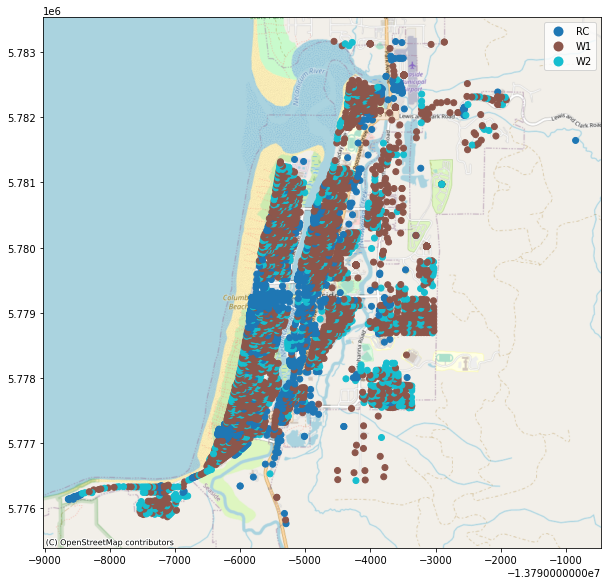

In [4]:
bldg_dataset_id = "613ba5ef5d3b1d6461e8c415"        # defining building dataset (GIS point layer)
bldg_dataset = Dataset.from_data_service(bldg_dataset_id, data_service)
geoviz.plot_map(bldg_dataset, column='struct_typ',category='True')
bldg_df = bldg_dataset.get_dataframe_from_shapefile()
bldg_df.set_index('guid', inplace=True)
print('Number of buildings: {}' .format(len(bldg_df)))


#### Electric
The electric infrastructure was originallly collected by Kameshwar *et al.* (2019) and consists of electric poles, an electric substation, and electric power lines. Each building parcel in Seaside is mapped to the nearest electric pole.

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...
Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


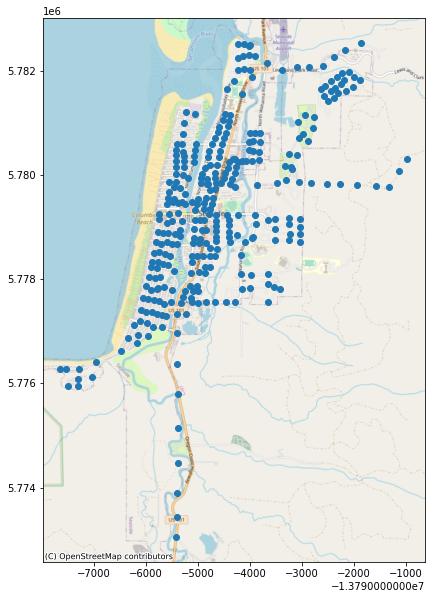

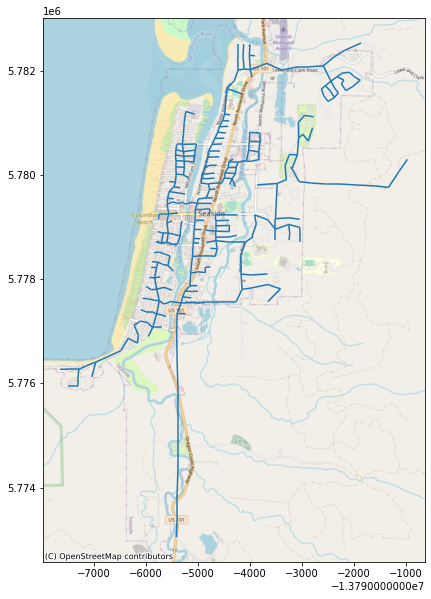

In [5]:
elec_pole_dataset_id = "5d263f08b9219cf93c056c68"        # defining electric pole dataset (GIS point layer)
elec_pole_dataset = Dataset.from_data_service(elec_pole_dataset_id, data_service)
geoviz.plot_map(elec_pole_dataset, column=None, category=False)


elec_line_dataset_id = "60e5e326544e944c3ce37a93"        # defining electric line dataset (GIS point layer)
elec_line_dataset = Dataset.from_data_service(elec_line_dataset_id, data_service)
geoviz.plot_map(elec_line_dataset, column=None, category=False)

#### Transportation
The transportation infrastructure was originallly collected by Kameshwar *et al.* (2019) and consists of roads and bridges. Each parcel in Seaside is mapped to the nearest node in the transportation network.


Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...
Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


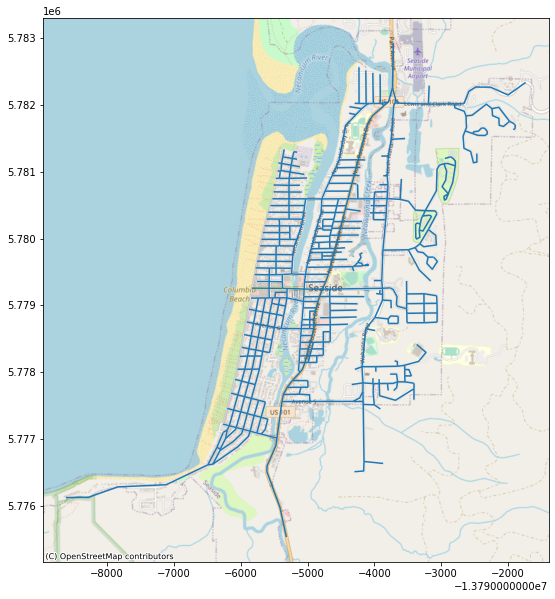

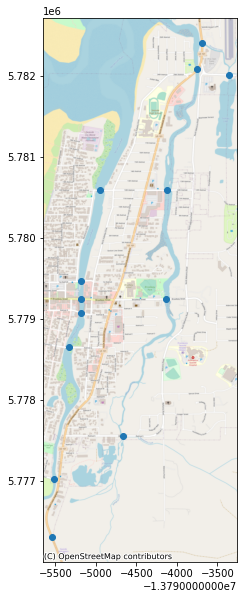

In [6]:
trns_road_dataset_id = "60e5e5cd544e944c3ce37d08"        # defining transportation road dataset (GIS point layer)
trns_road_dataset = Dataset.from_data_service(trns_road_dataset_id, data_service)
geoviz.plot_map(trns_road_dataset, column=None, category=False)


trns_brdg_dataset_id = "60e5e576d3c92a78c893ff69"        # defining transportation bridge dataset (GIS point layer)
trns_brdg_dataset = Dataset.from_data_service(trns_brdg_dataset_id, data_service)
geoviz.plot_map(trns_brdg_dataset, column=None, category=False, basemap=True)


#### Water
The water infrastructure was originallly collected by Kameshwar *et al.* (2019) and consists of water pipes, a water treatment plant, and three water pumping stations. Each building parcel in Seaside is mapped to the nearest node in the water network.

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...
Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


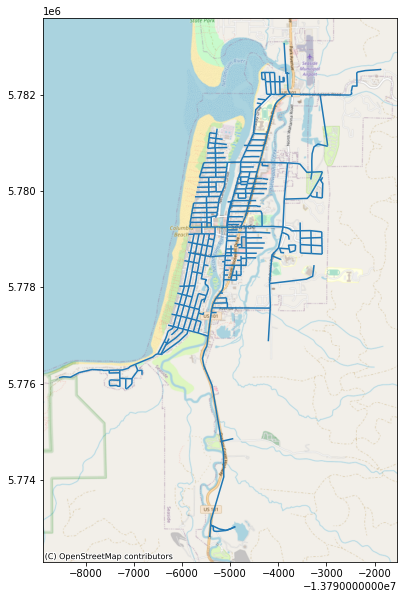

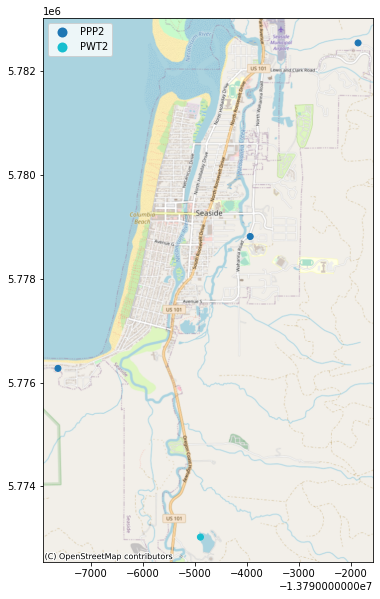

In [7]:
wter_pipe_dataset_id = "60e72f9fd3c92a78c89636c7"        # defining water pipes (GIS point layer)
wter_pipe_dataset = Dataset.from_data_service(wter_pipe_dataset_id, data_service)
geoviz.plot_map(wter_pipe_dataset, column=None, category=False)

wter_fclty_dataset_id = "60e5e91960b3f41243faa3b2"        # defining water facilities (GIS point layer)
wter_fclty_dataset = Dataset.from_data_service(wter_fclty_dataset_id, data_service)
geoviz.plot_map(wter_fclty_dataset, column='utilfcltyc', category=True)


<a id='1b'></a>
### 1b) Social Systems

Seaside has a permanent resident population of approximately 6,700 people.

This section performs a housing unit allocation. The housing unit inventory includes characteristics for individual households and housing units that can be linked to residential buildings. 
For more information see Rosenheim et al. (2019)



In [8]:
# Create housing allocation 
hua = HousingUnitAllocation(client)

# Load input dataset
housing_unit_inv_id = "5d543087b9219c0689b98234"
address_point_inv_id = "5d542fefb9219c0689b981fb"
bldg_inv_id = "613ba5ef5d3b1d6461e8c415" 

hua.load_remote_input_dataset("housing_unit_inventory", housing_unit_inv_id)
hua.load_remote_input_dataset("address_point_inventory", address_point_inv_id)
hua.load_remote_input_dataset("buildings", bldg_inv_id) 


# Set analysis parameters
path_out = os.path.join(path_to_output, 'hua_0')
hua.set_parameter("result_name", path_out)
hua.set_parameter("seed", 1337)
hua.set_parameter("iterations", 1)
hua.run_analysis()



Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...
Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...
Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


True

#### Explore results from Housing Unit Allocation

In [9]:
# Retrieve result dataset
hua_result = hua.get_output_dataset("result")

# Convert dataset to Pandas DataFrame
hua_df = hua_result.get_dataframe_from_csv(low_memory=False)

# Display top 5 rows of output data
print(hua_df[['guid','numprec','ownershp','geometry','aphumerge']].head())

# keep observations where the housing unit characteristics have been allocated to a structure.
hua_df = hua_df.dropna(subset=['guid'])

                                   guid  numprec  ownershp  \
0  37532fb5-5107-478b-ab2c-158eb001c68b      3.0       1.0   
1  e38d8575-7880-4a8c-b6d7-225ab1cf9264      3.0       1.0   
2  66d39314-1c68-4634-a82c-8fcb37f529ff      3.0       1.0   
3  af5771b4-4f42-4166-b772-78a3706fa8ac      1.0       1.0   
4  8f6e055b-2df8-461b-80a0-ba0c1f65add5      7.0       1.0   

                                       geometry aphumerge  
0  POINT (-123.9034265041881 46.01749849919388)      both  
1  POINT (-123.8960661064165 46.01272230816045)      both  
2  POINT (-123.9002451964179 46.01352343272472)      both  
3  POINT (-123.9034265041881 46.01749849919388)      both  
4  POINT (-123.8971825599634 46.01202832179288)      both  


In [10]:
hua_df['Race Ethnicity'] = "0 Vacant HU No Race Ethnicity Data"
hua_df['Race Ethnicity'].notes = "Identify Race and Ethnicity Housing Unit Characteristics."

hua_df.loc[(hua_df['race'] == 1) & 
                        (hua_df['hispan'] == 0),'Race Ethnicity'] = "1 White alone, Not Hispanic"
hua_df.loc[(hua_df['race'] == 2) & 
                        (hua_df['hispan'] == 0),'Race Ethnicity'] = "2 Black alone, Not Hispanic"
hua_df.loc[(hua_df['race'].isin([3,4,5,6,7])) & 
                        (hua_df['hispan'] == 0),'Race Ethnicity'] = "3 Other Race, Not Hispanic"
hua_df.loc[(hua_df['hispan'] == 1),'Race Ethnicity'] = "4 Any Race, Hispanic"
hua_df.loc[(hua_df['gqtype'] >= 1),'Race Ethnicity'] = "5 Group Quarters no Race Ethnicity Data"

hua_df['Tenure Status'] = "0 No Tenure Status"
hua_df.loc[(hua_df['ownershp'] == 1),'Tenure Status'] = "1 Owner Occupied"
hua_df.loc[(hua_df['ownershp'] == 2),'Tenure Status'] = "2 Renter Occupied"
hua_df['Tenure Status'].notes = "Identify Tenure Status Housing Unit Characteristics."

hua_df.to_csv(os.path.join(path_to_output, 'hua_df.csv'))

# make pivot table
table = pd.pivot_table(hua_df, values='numprec', index=['Race Ethnicity'],
                                     margins = True, margins_name = 'Total',
                                     columns=['Tenure Status'], aggfunc=[np.sum]).rename(
    columns={'Total': 'Total Population', 'sum': ''})
table_title = "Table 1. Total Population by Race, Ethncity, and Tenure Status, Seaside, OR, 2010."
varformat = {('','Total Population'): "{:,.0f}",
             ('','0 No Tenure Status'): "{:,.0f}",
             ('','1 Owner Occupied'): "{:,.0f}",
             ('','2 Renter Occupied'): "{:,.0f}"}
table.style.set_caption(table_title).format(varformat)

/usr/local/Caskroom/miniconda/base/envs/pyincore/lib/python3.7/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


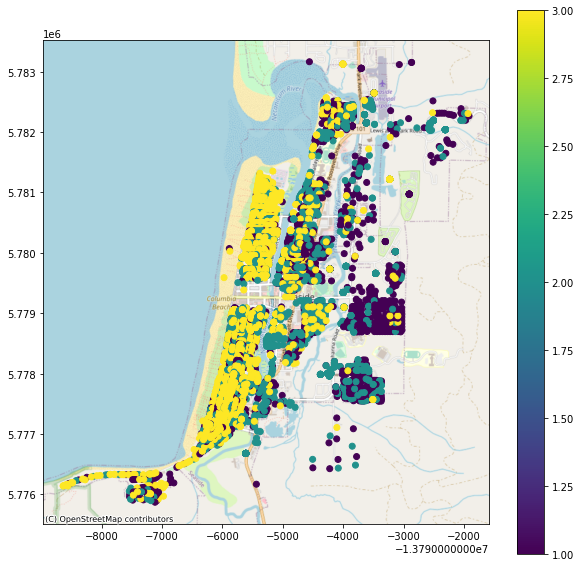

In [11]:
# Use shapely.wkt loads to convert WKT to GeoSeries
from shapely.geometry import Point
# Geodata frame requires geometry and CRS to be set
hua_gdf = gpd.GeoDataFrame(
    hua_df,
    crs={'init': 'epsg:4326'},
    geometry=[Point(xy) for xy in zip(hua_df['x'], hua_df['y'])])
hua_gdf[['guid','x','y','ownershp','geometry']].head(6)

# visualize population
gdf = hua_gdf
geoviz.plot_gdf_map(gdf, column='ownershp')

<a id='1c'></a>
### 1c) Economic Systems

For the CGE model, each parcel is mapped to an economic sector. The sector of each parcel is plotted spatially. 

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


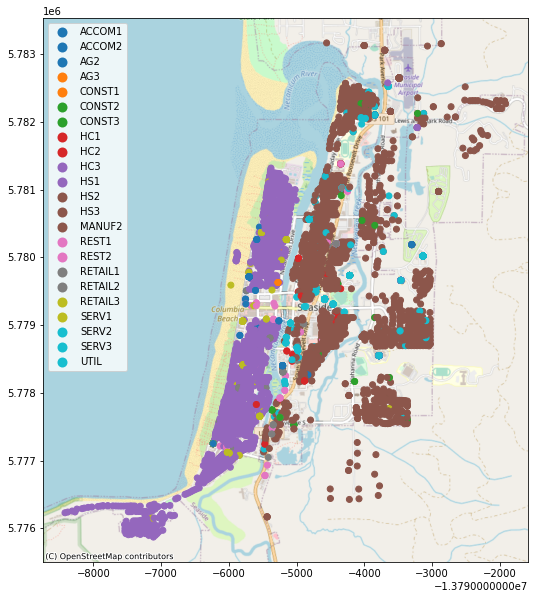

In [19]:
bldg2sector_id = "5f5fd8e2980a301080a03996"
bldg2sector_ds = Dataset.from_data_service(bldg2sector_id, data_service)
bldg2sector_df = bldg2sector_ds.get_dataframe_from_csv()


df = pd.merge(gdf, bldg2sector_df, left_on='guid', right_on='guid')
geoviz.plot_gdf_map(df, column='sector')

<a id='2'></a>
***
## 2) Hazards and Damages

![title](images/Flowchart_2.png)<br>

<a id='2a'></a>
### 2a) Hazard Models

The Seaside testbed uses hazard layers that were developed outside of IN-CORE. The hazard layers are the result of a Probabilistic Seismic and Tsunami Hazard Analysis (PSTHA; Park *et al.,* 2017b). The hazard layers and GUID's are in the table below

| Recurrence Interval | Earthquake | Tsunami |
| --- | --- | --- |
| 100-yr | 5dfa4058b9219c934b64d495 | 5bc9e25ef7b08533c7e610dc |
| 250-yr | 5dfa41aab9219c934b64d4b2 | 5df910abb9219cd00cf5f0a5 |
| 500-yr | 5dfa4300b9219c934b64d4d0 | 5df90e07b9219cd00ce971e7 |
| 1,000-yr | 5dfa3e36b9219c934b64c231 | 5df90137b9219cd00cb774ec |
| 2,500-yr | 5dfa4417b9219c934b64d4d3 | 5df90761b9219cd00ccff258 |
| 5,000-yr | 5dfbca0cb9219c101fd8a58d | 5df90871b9219cd00ccff273 |
| 10,000-yr | 5dfa51bfb9219c934b68e6c2 | 5d27b986b9219c3c55ad37d0 |

In [ ]:
eq_hazard_dict = {100: "5dfa4058b9219c934b64d495", 
                  250: "5dfa41aab9219c934b64d4b2",
                  500: "5dfa4300b9219c934b64d4d0",
                  1000: "5dfa3e36b9219c934b64c231",
                  2500: "5dfa4417b9219c934b64d4d3", 
                  5000: "5dfbca0cb9219c101fd8a58d",
                 10000: "5dfa51bfb9219c934b68e6c2"}

tsu_hazard_dict = {100: "5bc9e25ef7b08533c7e610dc", 
                  250: "5df910abb9219cd00cf5f0a5",
                  500: "5df90e07b9219cd00ce971e7",
                  1000: "5df90137b9219cd00cb774ec",
                  2500: "5df90761b9219cd00ccff258",
                  5000: "5df90871b9219cd00ccff273",
                  10000: "5d27b986b9219c3c55ad37d0"}

eq_demand = 'pga'
tsu_demand = 'Vmax'

eq_json = hazard_service.get_earthquake_hazard_metadata(hazard_id=eq_hazard_dict[ret_prd])
tsu_json = hazard_service.get_tsunami_hazard_metadata(hazard_id=tsu_hazard_dict[ret_prd])

for i in range(len(eq_json['hazardDatasets'])):
    if eq_json['hazardDatasets'][i]['demandType'].lower() == eq_demand.lower():
        eq_dataset = eq_json['hazardDatasets'][i]['datasetId']

for i in range(len(tsu_json['hazardDatasets'])):
    if tsu_json['hazardDatasets'][i]['demandType'].lower() == tsu_demand.lower():
        tsu_dataset = tsu_json['hazardDatasets'][i]['datasetId']

# geoviz.plot_raster_dataset(eq_json['hazardDatasets'][1]['datasetId'], client)
geoviz.plot_raster_dataset(tsu_json['hazardDatasets'][1]['datasetId'], client)


<a id='2b'></a>
### 2b) Damage Models

Seaside damage models are fragility curves from HAZUS. 

The fragility curve mapping ID's for Seaside are in the table below:

| Infrastructure System | Hazard | Mapping GUID |
| --- | --- | --- |
| Buildings | Earthquake | 5d2789dbb9219c3c553c7977 | 
| Buildings | Tsunami | 5d279bb9b9219c3c553c7fba | 
| Electric Poles | Earthquake | 6079f6a7ef881f48a4ace306 |
| Electric Poles | Tsunami | 6079c5e06799d908861f177c |
| Roads | Earthquake | 6079ec1aef881f48a4ac586c | 
| Roads | Tsunami | 6079c3bc6799d908861f16d4 | 
| Bridges | Earthquake | 6079f5435b609c56229bf85c | 
| Bridges | Tsunami | 6079c41a6799d908861f16fe | 
| Water Facilities | Earthquake | 5d39e010b9219cc18bd0b0b6 | 
| Water Facilities | Tsunami | 5d31f737b9219c6d66398521 | 
| Water Pipes | Earthquake | 5b47c227337d4a38464efea8 |
| Water Pipes | Tsunami | 5d320a87b9219c6d66398b45 |



#### Plotting some example fragility curves

In [ ]:
""" TODO: issues with plotting some of these mappings. Looks like it 
    needs a "vmax" value, but unsure where """

mapping_dict = {
    'buildings': 
        {'eq': '5d2789dbb9219c3c553c7977',
         'tsu': '5d279bb9b9219c3c553c7fba'},
    
    'electric_poles': 
        {'eq': '6079f6a7ef881f48a4ace306',
         'tsu': '6079c5e06799d908861f177c'}, # doesn't plot

    'roads': 
        {'eq': '6079ec1aef881f48a4ac586c',
        'tsu': '6079c3bc6799d908861f16d4'},  # doesn't plot
    
    'bridges': 
        {'eq': '6079f5435b609c56229bf85c',
         'tsu': '6079c41a6799d908861f16fe'},  # doesn't plot
    
    'water_pipe': 
        {'eq': '5b47c227337d4a38464efea8',
         'tsu': '5d320a87b9219c6d66398b45'},
    
    'water_facility': 
        {'eq': '6079f7825b609c56229bf976',
         'tsu': '6079b8a66799d908861e4bf0'},  # doesn't plot
}


mapping_id = mapping_dict['buildings']['eq']

mapping_set = MappingSet(fragility_services.get_mapping(mapping_id))

# plot fragility for the first 3 archetypes using pyincore viz method
for mapping in mapping_set.mappings[:3]:
    fragility_id = mapping.entry[list(mapping.entry.keys())[0]]
    fragility_set = FragilityCurveSet(fragility_services.get_dfr3_set(fragility_id))
    plt = plotviz.get_fragility_plot(fragility_set)

    plt.show()
    

#### Setting up a function to read Monte-Carlo results.

In [ ]:
def read_MC_results(path_to_mc, n_sims):
    """ Reads the building monte carlo results into a pandas dataframe.
        The output data from this analysis needs to be reformatted to be read by "read_csv"
    """
    replace_dict = {'DS_0': 0,
                    'DS_1': 1,
                    'DS_2': 2,
                    'DS_3': 3,
                    'DS_4': 4}
    
    df = pd.read_csv(path_to_mc)
    cols = [i for i in range(n_sims)]
    df[cols] = df['sample_damage_states'].str.split(',',expand=True)
    df.set_index('guid', inplace=True)    
    del df['sample_damage_states']
    df = df[cols].replace(replace_dict)
    
    return df

#### Setting up an alternative plotting function to plot buildings spatially.

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
def plot_gdf_map(gdf, column, category=False, basemap=True, source=ctx.providers.OpenStreetMap.Mapnik, **kwargs):
    """
    Taken from pyincore-viz. 
    Not using the pyincore-viz version b/c it's limited on plotting options
        - Added **kwargs for more control over the geopandas plotting function
    """
    fig, ax = plt.subplots(1,1, figsize=(10,15))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)

    gdf = gdf.to_crs(epsg=3857)
    ax = gdf.plot(figsize=(10, 10), 
                  column=column,
                  categorical=category, 
                  legend=True,
                  ax=ax,
                  cax=cax,
                 **kwargs)
    if basemap:
        ctx.add_basemap(ax, source=source)


#### Setting up a quick way to read pyIncore datasets into either dataframes or geodataframes.

In [ ]:
def read_pyincore_df(client, ds_id, index=None):
    """ reading pyincore dataset and loading into dataframe
    """
    ds = Dataset.from_data_service(ds_id, data_service)
    df = ds.get_dataframe_from_csv()
    if index != None:
        df = df.set_index(index)
    return df

def read_pyincore_gdf(client, ds_id, index=None):
    """ reading pyincore dataset and loading into a geodataframe
    """
    ds = Dataset.from_data_service(ds_id, data_service)
    df = ds.get_dataframe_from_shapefile()
    if index != None:
        df = df.set_index(index)
    return df

<a id='2c'></a>
### 2c) Damage to Physical Infrastructure


#### Building Damage
Running building damage for earthquake, tsunami, and cumulative earthquake+tsunami.

In [ ]:
# --- Earthquake
# initializing building damage and fragility service
bldg_dmg = BuildingDamage(client)   
fragility_service = FragilityService(client)

# defining building dataset (GIS point layer)
bldg_dataset_id = "613ba5ef5d3b1d6461e8c415"
bldg_dmg.load_remote_input_dataset("buildings", bldg_dataset_id)

# specifiying mapping id from fragilites to building types
mapping_id = "5d2789dbb9219c3c553c7977" # 4 DS
mapping_set = MappingSet(fragility_service.get_mapping(mapping_id))
bldg_dmg.set_input_dataset('dfr3_mapping_set', mapping_set)

bldg_dmg.set_parameter("hazard_type", "earthquake")
bldg_dmg.set_parameter("num_cpu", 4)

result_name = os.path.join(path_to_output, 'buildings_eq_{}yr' .format(ret_prd))
hazard_id = eq_hazard_dict[ret_prd]
bldg_dmg.set_parameter("hazard_id", hazard_id)
bldg_dmg.set_parameter("result_name", result_name)

bldg_dmg.run_analysis()
print('Earthquake done.')



# --- Tsunami
# initializing pyincore building damage and fragility service 
bldg_dmg = BuildingDamage(client)
fragility_service = FragilityService(client)

# defining building dataset (GIS point layer)
bldg_dataset_id = "613ba5ef5d3b1d6461e8c415"
bldg_dmg.load_remote_input_dataset("buildings", bldg_dataset_id)

# specifiying mapping id from fragilites to building types
mapping_id = "5d279bb9b9219c3c553c7fba" # 4 DS
mapping_set = MappingSet(fragility_service.get_mapping(mapping_id))
bldg_dmg.set_input_dataset('dfr3_mapping_set', mapping_set)

bldg_dmg.set_parameter("hazard_type", "tsunami")
bldg_dmg.set_parameter("num_cpu", 4)

result_name = os.path.join(path_to_output, 'buildings_tsu_{}yr' .format(ret_prd))
hazard_id = tsu_hazard_dict[ret_prd]
bldg_dmg.set_parameter("hazard_id", hazard_id)
bldg_dmg.set_parameter("result_name", result_name)

bldg_dmg.run_analysis()
print('Tsunami done.')




# --- Cumulative
# initializing pyIncore cumulative building damage
cumulative_bldg_dmg = CumulativeBuildingDamage(client)
cumulative_bldg_dmg.set_parameter("num_cpu", 4)

# reading in damage results from above analysis
eq_damage_results_csv = os.path.join(path_to_output, 'buildings_eq_{}yr.csv' .format(ret_prd))
tsu_damage_results_csv = os.path.join(path_to_output, 'buildings_tsu_{}yr.csv' .format(ret_prd))

# loading datasets from CSV files into pyincore
eq_damage_dataset = Dataset.from_file(eq_damage_results_csv, "ergo:buildingDamageVer5")
tsu_damage_dataset = Dataset.from_file(tsu_damage_results_csv, "ergo:buildingDamageVer5")

cumulative_bldg_dmg.set_input_dataset("eq_bldg_dmg", eq_damage_dataset)
cumulative_bldg_dmg.set_input_dataset("tsunami_bldg_dmg", tsu_damage_dataset)

# defining path to output 
result_name = os.path.join(path_to_output, 'buildings_cumulative_{}yr' .format(ret_prd))
cumulative_bldg_dmg.set_parameter("result_name", result_name)

# running analysis
cumulative_bldg_dmg.run_analysis()
print('Cumulative done.')

Building MC Sampling

In [ ]:
building_dmg_result = cumulative_bldg_dmg.get_output_dataset('combined-result')

path_to_mc_results = os.path.join(path_to_output, 'mc_buildings_cumulative_{}yr' .format(ret_prd))

mc_bldg = MonteCarloFailureProbability(client)
mc_bldg.set_input_dataset("damage", building_dmg_result)
mc_bldg.set_parameter("num_cpu", 8)
mc_bldg.set_parameter("num_samples", n_sims)
mc_bldg.set_parameter("damage_interval_keys", ["DS_0", "DS_1", "DS_2", "DS_3"])
mc_bldg.set_parameter("failure_state_keys", ["DS_1", "DS_2", "DS_3"])

mc_bldg.set_parameter("result_name", path_to_mc_results) # name of csv file with results
mc_bldg.run()

**Explore Monte-Carlo Building Damage Results**

Each row is a parcel, each column is a sample from the Monte-Carlo analysis. 
+ 0: No/Insignificant Damage
+ 1: Moderate Damage
+ 2: Heavy Damage
+ 3: Complete Damage

In [ ]:
path_to_df = os.path.join(path_to_output, 'mc_buildings_cumulative_{}yr_sample_damage_states.csv' .format(ret_prd))
mc_df = read_MC_results(path_to_df, n_sims)
mc_df.head()

In [ ]:
mc_df['avg'] = mc_df.mean(axis=1) # getting average of MC results

# reading pyIncore dataset to geodataframe
bldg_dataset_id = "613ba5ef5d3b1d6461e8c415"        # defining building dataset (GIS point layer)
bldg_gdf = read_pyincore_gdf(client, bldg_dataset_id, index='guid')

# merging the two above
bldg_mc_df = pd.merge(bldg_gdf, mc_df['avg'], left_index=True, right_index=True)

# plotting results
plot_gdf_map(bldg_mc_df, column='avg', vmin=0, vmax=3, s=4, cmap='magma')

####  Electric Damage
Running electric power network damage for earthquake, tsunami, and cumulative earthquake+tsunami. 

In [ ]:
# --- Earthquake 
# initializing epf damage and fragility service
epf_dmg = EpfDamage(client)
fragility_service = FragilityService(client)

# defining electric pole dataset (GIS point layer)
poles_ss_id = "5d263f08b9219cf93c056c68"     # elelctric power poles and substation
epf_dmg.load_remote_input_dataset("epfs", poles_ss_id)

# Fragility Mapping on incore-service
mapping_id = "5d489aa1b9219c0689f1988e" # 5 DS
# mapping_id = "6079f6a7ef881f48a4ace306" # 4 DS
mapping_set = MappingSet(fragility_service.get_mapping(mapping_id))
epf_dmg.set_input_dataset('dfr3_mapping_set', mapping_set)

epf_dmg.set_parameter("hazard_type", 'earthquake')
epf_dmg.set_parameter("num_cpu", 4)
epf_dmg.set_parameter('fragility_key', "pga")

result_name = os.path.join(path_to_output, 'electric_eq_{}yr'.format(ret_prd))
hazard_id = eq_hazard_dict[ret_prd]

epf_dmg.set_parameter("hazard_id", hazard_id)
epf_dmg.set_parameter("result_name", result_name)

# Run Analysis
epf_dmg.run_analysis()
print('Earthquake done.')


# --- Tsunami
# Initializing EPF damage and fragility service
epf_dmg = EpfDamage(client)
fragility_service = FragilityService(client)

# defining electric poles and substation dataset (GIS point layer)
poles_ss_id = "5d263f08b9219cf93c056c68"
epf_dmg.load_remote_input_dataset("epfs", poles_ss_id)

# Fragility Mapping on incore-service
mapping_id = "5d31eb7fb9219c6d66398445" # 5 DS
# mapping_id = "6079c5e06799d908861f177c" # 4 DS
mapping_set = MappingSet(fragility_service.get_mapping(mapping_id))
epf_dmg.set_input_dataset('dfr3_mapping_set', mapping_set)

epf_dmg.set_parameter("hazard_type", "tsunami")
epf_dmg.set_parameter("num_cpu", 4)
epf_dmg.set_parameter('fragility_key', "Non-Retrofit inundationDepth Fragility ID Code")

result_name = os.path.join(path_to_output, 'electric_tsu_{}yr'.format(ret_prd))
hazard_id = tsu_hazard_dict[ret_prd]

epf_dmg.set_parameter("hazard_id", hazard_id)
epf_dmg.set_parameter("result_name", result_name)

# Run Analysis
epf_dmg.run_analysis()
print('Tsunami done.')


# --- Cumulative
print('\nCumulative electric damage does not exist in pyIncore yet. Doing manually.')
path_to_eq = os.path.join(path_to_output, 'electric_eq_{}yr.csv' .format(ret_prd))
path_to_ts = os.path.join(path_to_output, 'electric_tsu_{}yr.csv' .format(ret_prd))

eq_df = pd.read_csv(path_to_eq, index_col=0)
ts_df = pd.read_csv(path_to_ts, index_col=0)

cumulative = pd.DataFrame(index=eq_df.index)
cumulative["LS_0"] = eq_df["LS_0"] + ts_df["LS_0"] \
    - eq_df["LS_0"] * ts_df["LS_0"]

cumulative["LS_1"] = eq_df["LS_1"] + ts_df["LS_1"] - eq_df["LS_1"] * ts_df["LS_1"] \
    + ((eq_df["LS_0"] - eq_df["LS_1"]) * (ts_df["LS_0"] - ts_df["LS_1"]))

cumulative["LS_2"] = eq_df["LS_2"] + ts_df["LS_2"] \
    - eq_df["LS_2"] * ts_df["LS_2"] \
    + ((eq_df["LS_1"] - eq_df["LS_2"]) * (ts_df["LS_1"] - ts_df["LS_2"]))

cumulative["LS_3"] = eq_df["LS_3"] + ts_df["LS_3"] \
    - eq_df["LS_3"] * ts_df["LS_3"] \
    + ((eq_df["LS_2"] - eq_df["LS_3"]) * (ts_df["LS_2"] - ts_df["LS_3"]))

cumulative['DS_0'] = 1-cumulative['LS_0']
cumulative['DS_1'] = cumulative['LS_0'] - cumulative['LS_1']
cumulative['DS_2'] = cumulative['LS_1'] - cumulative['LS_2']
cumulative['DS_3'] = cumulative['LS_2'] - cumulative['LS_3']
cumulative['DS_4'] = cumulative['LS_3']

cumulative['hazard'] = 'Earthquake+Tsunami'
path_to_cumulative = os.path.join(path_to_output, 'electric_cumulative_{}yr.csv' .format(ret_prd))
cumulative.to_csv(path_to_cumulative)

Electric MC Sampling

In [ ]:
elec_dmg_result = Dataset.from_file(path_to_cumulative, data_type='incore:epfDamage')
path_to_mc_results = os.path.join(path_to_output, 'mc_electric_cumulative_{}yr' .format(ret_prd))

mc = MonteCarloFailureProbability(client)
mc.set_input_dataset("damage", elec_dmg_result)
mc.set_parameter("num_cpu", 8)
mc.set_parameter("num_samples", n_sims)
mc.set_parameter("damage_interval_keys", ["DS_0", "DS_1", "DS_2", "DS_3", "DS_4"])
mc.set_parameter("failure_state_keys", ["DS_1", "DS_2", "DS_3", "DS_4"])

mc.set_parameter("result_name", path_to_mc_results) # name of csv file with results
mc.run()

**Explore Monte-Carlo Electric Damage Results**

Each row is an infrastructure component, each column is a sample from the Monte-Carlo analysis. 
+ 0: No/Insignificant Damage
+ 1: Moderate Damage
+ 2: Heavy Damage
+ 3: Complete Damage

In [ ]:
path_to_df = os.path.join(path_to_output, 'mc_electric_cumulative_{}yr_sample_damage_states.csv' .format(ret_prd))
mc_df = read_MC_results(path_to_df, n_sims)
mc_df.head()

In [ ]:
mc_df['avg'] = mc_df.mean(axis=1) # getting average of MC results

# reading pyIncore dataset to geodataframe
elec_dataset_id = "5d263f08b9219cf93c056c68"        # defining building dataset (GIS point layer)
elec_gdf = read_pyincore_gdf(client, elec_dataset_id, index='guid')

# merging the two above
elec_mc_df = pd.merge(elec_gdf, mc_df['avg'], left_index=True, right_index=True)

# plotting results
plot_gdf_map(elec_mc_df, column='avg', vmin=0, vmax=3, s=40, cmap='RdBu_r', edgecolor='0.5', linewidth=0.5)

####  Transportation Damage
Running road and bridge damage for earthquake, tsunami, and cumulative earthquake+tsunami.

In [ ]:
# --- Earthquake
# Road damage
# Initializing road damage and fragility service
road_dmg = RoadDamage(client)
fragility_service = FragilityService(client)

# loading in road dataset
road_dataset_id = "60e5e5cd544e944c3ce37d08"
road_dmg.load_remote_input_dataset("roads", road_dataset_id)

# seaside road fragility mappng for EQ
mapping_id = "5d545b0bb9219c0689f1f3f4" # 5 DS
# mapping_id = "6079ec1aef881f48a4ac586c" # 4 DS
mapping_set = MappingSet(fragility_service.get_mapping(mapping_id))
road_dmg.set_input_dataset('dfr3_mapping_set', mapping_set)

road_dmg.set_parameter("hazard_type", 'earthquake')
road_dmg.set_parameter("num_cpu", 4)
road_dmg.set_parameter("fragility_key", 'pgd')

result_name = os.path.join(path_to_output, 'road_eq_{}yr' .format(ret_prd))
hazard_id = eq_hazard_dict[ret_prd]

road_dmg.set_parameter("hazard_id", hazard_id)
road_dmg.set_parameter("result_name", result_name)

road_dmg.run_analysis()


# Bridge damage
# initializing bridge damage and fragility service
brdg_dmg = BridgeDamage(client)
fragility_service = FragilityService(client)

# Seaside bridges
bridge_dataset_id = "60e5e576d3c92a78c893ff69"
brdg_dmg.load_remote_input_dataset("bridges", bridge_dataset_id)

# Set analysis parameters

# seaside road fragility mappng for EQ
mapping_id = "5d55c3a1b9219c0689f1f898" # 5 DS
# mapping_id = "6079f5435b609c56229bf85c" # 4 DS
mapping_set = MappingSet(fragility_service.get_mapping(mapping_id))
brdg_dmg.set_input_dataset('dfr3_mapping_set', mapping_set)

brdg_dmg.set_parameter("hazard_type", 'earthquake')
brdg_dmg.set_parameter("num_cpu", 4)

result_name = os.path.join(path_to_output, 'bridge_eq_{}yr' .format(ret_prd))
hazard_id = eq_hazard_dict[ret_prd]
brdg_dmg.set_parameter("hazard_id", hazard_id)
brdg_dmg.set_parameter("result_name", result_name)

brdg_dmg.run_analysis()
print('Earthquake done.')








# --- Tsunami
# Road damage
# Initializing road damage and fragility service
road_dmg = RoadDamage(client)
fragility_service = FragilityService(client)

# loading road dataset
road_dataset_id = "60e5e5cd544e944c3ce37d08"
road_dmg.load_remote_input_dataset("roads", road_dataset_id)

# seaside road fragility mappng for tsunami
mapping_id = "5d274fd8b9219c3c553c71ff" # 5 DS
# mapping_id = "6079c3bc6799d908861f16d4" # 4 DS
mapping_set = MappingSet(fragility_service.get_mapping(mapping_id))
road_dmg.set_input_dataset('dfr3_mapping_set', mapping_set)

road_dmg.set_parameter("hazard_type", 'tsunami')
road_dmg.set_parameter("num_cpu", 4)
road_dmg.set_parameter("fragility_key", "Non-Retrofit inundationDepth Fragility ID Code")


result_name = os.path.join(path_to_output, 'road_tsu_{}yr' .format(ret_prd))
hazard_id = tsu_hazard_dict[ret_prd]

road_dmg.set_parameter("hazard_id", hazard_id)
road_dmg.set_parameter("result_name", result_name)

road_dmg.run_analysis()




# Bridge damage

# Initialzing bridge damage and fragility service
brdg_dmg = BridgeDamage(client)
fragility_service = FragilityService(client)

# Seaside bridges
bridge_dataset_id = "60e5e576d3c92a78c893ff69"
brdg_dmg.load_remote_input_dataset("bridges", bridge_dataset_id)

# seaside road fragility mappng for EQ
mapping_id = "5d275000b9219c3c553c7202"	# 5 DS
# mapping_id = "6079c41a6799d908861f16fe" # 4 DS
mapping_set = MappingSet(fragility_service.get_mapping(mapping_id))
brdg_dmg.set_input_dataset('dfr3_mapping_set', mapping_set)

brdg_dmg.set_parameter("hazard_type", 'tsunami')

result_name = os.path.join(path_to_output, 'bridge_tsu_{}yr' .format(ret_prd))
hazard_id = tsu_hazard_dict[ret_prd]
brdg_dmg.set_parameter("hazard_id", hazard_id)
brdg_dmg.set_parameter("result_name", result_name)

brdg_dmg.run_analysis()
print('Tsunami done.')


# --- Cumualtive
print('\nCumulative transportation damage does not exist in pyIncore yet. Doing manually')

# Road Damage

path_to_eq = os.path.join(path_to_output, 'road_eq_{}yr.csv' .format(ret_prd))
path_to_ts = os.path.join(path_to_output, 'road_tsu_{}yr.csv' .format(ret_prd))

eq_df = pd.read_csv(path_to_eq, index_col=0)
ts_df = pd.read_csv(path_to_ts, index_col=0)

cumulative = pd.DataFrame(index=eq_df.index)
cumulative["LS_0"] = eq_df["LS_0"] + ts_df["LS_0"] \
    - eq_df["LS_0"] * ts_df["LS_0"]

cumulative["LS_1"] = eq_df["LS_1"] + ts_df["LS_1"] - eq_df["LS_1"] * ts_df["LS_1"] \
    + ((eq_df["LS_0"] - eq_df["LS_1"]) * (ts_df["LS_0"] - ts_df["LS_1"]))

cumulative["LS_2"] = eq_df["LS_2"] + ts_df["LS_2"] \
    - eq_df["LS_2"] * ts_df["LS_2"] \
    + ((eq_df["LS_1"] - eq_df["LS_2"]) * (ts_df["LS_1"] - ts_df["LS_2"]))

cumulative["LS_3"] = eq_df["LS_3"] + ts_df["LS_3"] \
    - eq_df["LS_3"] * ts_df["LS_3"] \
    + ((eq_df["LS_2"] - eq_df["LS_3"]) * (ts_df["LS_2"] - ts_df["LS_3"]))

cumulative['DS_0'] = 1-cumulative['LS_0']
cumulative['DS_1'] = cumulative['LS_0'] - cumulative['LS_1']
cumulative['DS_2'] = cumulative['LS_1'] - cumulative['LS_2']
cumulative['DS_3'] = cumulative['LS_2'] - cumulative['LS_3']
cumulative['DS_4'] = cumulative['LS_3']

cumulative['hazard'] = 'Earthquake+Tsunami'
path_to_cumulative = os.path.join(path_to_output, 'road_cumulative_{}yr.csv' .format(ret_prd))
cumulative.to_csv(path_to_cumulative)


# Bridge Damage

path_to_eq = os.path.join(path_to_output, 'bridge_eq_{}yr.csv' .format(ret_prd))
path_to_ts = os.path.join(path_to_output, 'bridge_tsu_{}yr.csv' .format(ret_prd))

eq_df = pd.read_csv(path_to_eq, index_col=0)
ts_df = pd.read_csv(path_to_ts, index_col=0)

cumulative = pd.DataFrame(index=eq_df.index)
cumulative["LS_0"] = eq_df["LS_0"] + ts_df["LS_0"] \
    - eq_df["LS_0"] * ts_df["LS_0"]

cumulative["LS_1"] = eq_df["LS_1"] + ts_df["LS_1"] - eq_df["LS_1"] * ts_df["LS_1"] \
    + ((eq_df["LS_0"] - eq_df["LS_1"]) * (ts_df["LS_0"] - ts_df["LS_1"]))

cumulative["LS_2"] = eq_df["LS_2"] + ts_df["LS_2"] \
    - eq_df["LS_2"] * ts_df["LS_2"] \
    + ((eq_df["LS_1"] - eq_df["LS_2"]) * (ts_df["LS_1"] - ts_df["LS_2"]))

cumulative["LS_3"] = eq_df["LS_3"] + ts_df["LS_3"] \
    - eq_df["LS_3"] * ts_df["LS_3"] \
    + ((eq_df["LS_2"] - eq_df["LS_3"]) * (ts_df["LS_2"] - ts_df["LS_3"]))

cumulative['DS_0'] = 1-cumulative['LS_0']
cumulative['DS_1'] = cumulative['LS_0'] - cumulative['LS_1']
cumulative['DS_2'] = cumulative['LS_1'] - cumulative['LS_2']
cumulative['DS_3'] = cumulative['LS_2'] - cumulative['LS_3']
cumulative['DS_4'] = cumulative['LS_3']

cumulative['hazard'] = 'Earthquake+Tsunami'
path_to_cumulative = os.path.join(path_to_output, 'bridge_cumulative_{}yr.csv' .format(ret_prd))
cumulative.to_csv(path_to_cumulative)

Transportation MC Sampling

In [ ]:
# Road
path_to_cumulative = os.path.join(path_to_output, 'road_cumulative_{}yr.csv' .format(ret_prd))
road_dmg_result = Dataset.from_file(path_to_cumulative, data_type='ergo:roadDamageVer3')
path_to_mc_results = os.path.join(path_to_output, 'mc_road_cumulative_{}yr' .format(ret_prd))

mc = MonteCarloFailureProbability(client)
mc.set_input_dataset("damage", road_dmg_result)
mc.set_parameter("num_cpu", 8)
mc.set_parameter("num_samples", n_sims)
mc.set_parameter("damage_interval_keys", ["DS_0", "DS_1", "DS_2", "DS_3", "DS_4"])
mc.set_parameter("failure_state_keys", ["DS_1", "DS_2", "DS_3", "DS_4"])

mc.set_parameter("result_name", path_to_mc_results) # name of csv file with results
mc.run()

path_to_df = os.path.join(path_to_output, 'mc_road_cumulative_{}yr_sample_damage_states.csv' .format(ret_prd))
df = read_MC_results(path_to_df, n_sims)
df



# Bridge
path_to_cumulative = os.path.join(path_to_output, 'bridge_cumulative_{}yr.csv' .format(ret_prd))
brdg_dmg_result = Dataset.from_file(path_to_cumulative, data_type='ergo:bridgeDamageVer3')
path_to_mc_results = os.path.join(path_to_output, 'mc_bridge_cumulative_{}yr' .format(ret_prd))

mc = MonteCarloFailureProbability(client)
mc.set_input_dataset("damage", brdg_dmg_result)
mc.set_parameter("num_cpu", 8)
mc.set_parameter("num_samples", n_sims)
mc.set_parameter("damage_interval_keys", ["DS_0", "DS_1", "DS_2", "DS_3", "DS_4"])
mc.set_parameter("failure_state_keys", ["DS_1", "DS_2", "DS_3", "DS_4"])

mc.set_parameter("result_name", path_to_mc_results) # name of csv file with results
mc.run()

**Explore Monte-Carlo Transportation Damage Results**

Only showing road damage results. Each row is a road component, each column is a sample from the Monte-Carlo analysis. 
+ 0: No/Insignificant Damage
+ 1: Moderate Damage
+ 2: Heavy Damage
+ 3: Complete Damage

In [ ]:
path_to_df = os.path.join(path_to_output, 'mc_road_cumulative_{}yr_sample_damage_states.csv' .format(ret_prd))
mc_df = read_MC_results(path_to_df, n_sims)
mc_df.head()

In [ ]:
mc_df['avg'] = mc_df.mean(axis=1) # getting average of MC results

# reading pyIncore dataset to geodataframe
road_dataset_id = "60e5e5cd544e944c3ce37d08"
road_gdf = read_pyincore_gdf(client, road_dataset_id, index='guid')

# merging the two above
road_mc_df = pd.merge(road_gdf, mc_df['avg'], left_index=True, right_index=True)

# plotting results
plot_gdf_map(road_mc_df, column='avg', vmin=0, vmax=3, cmap='RdBu_r', linewidth=4)

#### Water Damage
Running water facility and water pipe damage for earthquake, tsunami, and cumulative earthquake+tsunami.

In [ ]:
# --- Earthquake
# Pipe damage
# Initializing pipeline damage and fragility service
pipeline_dmg = PipelineDamageRepairRate(client)
fragility_service = FragilityService(client)

# Seaside pipes
pipe_dataset_id = "60e72f9fd3c92a78c89636c7"
pipeline_dmg.load_remote_input_dataset("pipeline", pipe_dataset_id)


# seaside pipe fragility mappng for EQ
mapping_id = "5b47c227337d4a38464efea8"
mapping_set = MappingSet(fragility_service.get_mapping(mapping_id))
pipeline_dmg.set_input_dataset('dfr3_mapping_set', mapping_set)

pipeline_dmg.set_parameter("hazard_type", 'earthquake')
pipeline_dmg.set_parameter("fragility_key",'pgv')
# pipeline_dmg.set_parameter("use_liquefaction",True)
pipeline_dmg.set_parameter("num_cpu", 4)

result_name = os.path.join(path_to_output, 'pipe_eq_{}yr' .format(ret_prd))
hazard_id = eq_hazard_dict[ret_prd]

pipeline_dmg.set_parameter("hazard_id", hazard_id)
pipeline_dmg.set_parameter("result_name",result_name)

# Run pipeline damage analysis
result = pipeline_dmg.run_analysis()




# Facility damage    
# Initializing water facility damage and fragility service
wterfclty_dmg = WaterFacilityDamage(client)
fragility_service = FragilityService(client)

# loading input dataset
fclty_dataset_id = "60e5e91960b3f41243faa3b2"
wterfclty_dmg.load_remote_input_dataset("water_facilities", fclty_dataset_id)

# wterfclty Fragility Mapping on incore-service
mapping_id = "5d39e010b9219cc18bd0b0b6" # 5 DS
# mapping_id = "6079f7825b609c56229bf976" # 4 DS
mapping_set = MappingSet(fragility_service.get_mapping(mapping_id))
wterfclty_dmg.set_input_dataset('dfr3_mapping_set', mapping_set)

wterfclty_dmg.set_parameter("hazard_type", 'earthquake')
wterfclty_dmg.set_parameter("fragility_key",'pga')
wterfclty_dmg.set_parameter("num_cpu", 4)

result_name = os.path.join(path_to_output, 'wterfclty_eq_{}yr' .format(ret_prd))
hazard_id = eq_hazard_dict[ret_prd]

wterfclty_dmg.set_parameter("hazard_id", hazard_id)
wterfclty_dmg.set_parameter("result_name",result_name)

# Run pipeline damage analysis
result = wterfclty_dmg.run_analysis()
print('Earthquake done.')





# --- Tsunami damage
# Pipe damage
# Initialzing pipeline damage and fragility service
pipeline_dmg = PipelineDamage(client)
fragility_service = FragilityService(client)

# Seaside pipes
pipe_dataset_id = "60e72f9fd3c92a78c89636c7"
pipeline_dmg.load_remote_input_dataset("pipeline", pipe_dataset_id)

# seaside pipe fragility mappng for tsunami
mapping_id = "5d320a87b9219c6d66398b45" # 5 DS
# mapping_id = "6079b7156799d908861e413b" # 4 DS
mapping_set = MappingSet(fragility_service.get_mapping(mapping_id))
pipeline_dmg.set_input_dataset('dfr3_mapping_set', mapping_set)

pipeline_dmg.set_parameter("hazard_type", 'tsunami')
pipeline_dmg.set_parameter("fragility_key", "Non-Retrofit inundationDepth Fragility ID Code")
pipeline_dmg.set_parameter("num_cpu", 4)

result_name = os.path.join(path_to_output, 'pipe_tsu_{}yr' .format(ret_prd))
hazard_id = tsu_hazard_dict[ret_prd]

pipeline_dmg.set_parameter("hazard_id", hazard_id)
pipeline_dmg.set_parameter("result_name",result_name)

# Run pipeline damage analysis
result = pipeline_dmg.run_analysis()



# Facility damage
# initialzing water facility damage and fragility service
wterfclty_dmg = WaterFacilityDamage(client)
fragility_service = FragilityService(client)

# loading input dataset
fclty_dataset_id = "60e5e91960b3f41243faa3b2"
wterfclty_dmg.load_remote_input_dataset("water_facilities", fclty_dataset_id)

# wterfclty Fragility Mapping on incore-service
mapping_id = "5d31f737b9219c6d66398521" # 5 DS
# mapping_id = "6079b8a66799d908861e4bf0" # 4 DS
mapping_set = MappingSet(fragility_service.get_mapping(mapping_id))
wterfclty_dmg.set_input_dataset('dfr3_mapping_set', mapping_set)

wterfclty_dmg.set_parameter("hazard_type", 'tsunami')
wterfclty_dmg.set_parameter("fragility_key","Non-Retrofit inundationDepth Fragility ID Code")
wterfclty_dmg.set_parameter("num_cpu", 4)


result_name = os.path.join(path_to_output, 'wterfclty_tsu_{}yr' .format(ret_prd))
hazard_id = tsu_hazard_dict[ret_prd]

wterfclty_dmg.set_parameter("hazard_id", hazard_id)
wterfclty_dmg.set_parameter("result_name",result_name)

# Run facility damage analysis
result = wterfclty_dmg.run_analysis()
print('Tsunami done.')




# --- Cumulative
print('\nCumulative water damage does not exist in pyIncore yet.')


# Pipeline damage
""" doing MC sampling here for pipes
    returns mc results:
        0: failed
        1: working
"""

path_to_eq = os.path.join(path_to_output, 'pipe_eq_{}yr.csv' .format(ret_prd))
path_to_ts = os.path.join(path_to_output, 'pipe_tsu_{}yr.csv' .format(ret_prd))

eq_df = pd.read_csv(path_to_eq, index_col=0)
ts_df = pd.read_csv(path_to_ts, index_col=0)


""" pyincore returns failure probs for EQ.
    assuming pipe has failed if in extensive or complete for tsunami. From HAZUS TMTM
        Slight: pipeline exposedd due soil erosion; no leakage
        Moderate: some displacement in pipeline, requiring minor repairs
        Extensive: pipeline damaged (mainly joint failure) resulting in leakage
        Complete: multiple pipeline separations at joint and barrel, requiring replacement
"""
ts_df['failprob'] = ts_df['DS_3'] + ts_df['DS_4']

cumulative_failure_df = pd.DataFrame(index=eq_df.index)
for i in range(n_sims):
    rv_eq = np.random.uniform(low=0, high=1., size=len(eq_df))
    rv_ts = np.random.uniform(low=0, high=1., size=len(ts_df))

    eq_mc = rv_eq<eq_df['failprob']
    ts_mc = rv_ts<ts_df['failprob']

    cumulative_failure_df[i] = np.logical_or(eq_mc.values, ts_mc.values).astype(int)
path_to_mc_results = os.path.join(path_to_output, 'mc_wterpipe_cumulative_{}yr.csv' .format(ret_prd))
cumulative_failure_df.to_csv(path_to_mc_results)

# Facility Damage

path_to_eq = os.path.join(path_to_output, 'wterfclty_eq_{}yr.csv' .format(ret_prd))
path_to_ts = os.path.join(path_to_output, 'wterfclty_tsu_{}yr.csv' .format(ret_prd))

eq_df = pd.read_csv(path_to_eq, index_col=0)
ts_df = pd.read_csv(path_to_ts, index_col=0)

cumulative = pd.DataFrame(index=eq_df.index)
cumulative["LS_0"] = eq_df["LS_0"] + ts_df["LS_0"] \
    - eq_df["LS_0"] * ts_df["LS_0"]

cumulative["LS_1"] = eq_df["LS_1"] + ts_df["LS_1"] - eq_df["LS_1"] * ts_df["LS_1"] \
    + ((eq_df["LS_0"] - eq_df["LS_1"]) * (ts_df["LS_0"] - ts_df["LS_1"]))

cumulative["LS_2"] = eq_df["LS_2"] + ts_df["LS_2"] \
    - eq_df["LS_2"] * ts_df["LS_2"] \
    + ((eq_df["LS_1"] - eq_df["LS_2"]) * (ts_df["LS_1"] - ts_df["LS_2"]))

cumulative["LS_3"] = eq_df["LS_3"] + ts_df["LS_3"] \
    - eq_df["LS_3"] * ts_df["LS_3"] \
    + ((eq_df["LS_2"] - eq_df["LS_3"]) * (ts_df["LS_2"] - ts_df["LS_3"]))

cumulative['DS_0'] = 1-cumulative['LS_0']
cumulative['DS_1'] = cumulative['LS_0'] - cumulative['LS_1']
cumulative['DS_2'] = cumulative['LS_1'] - cumulative['LS_2']
cumulative['DS_3'] = cumulative['LS_2'] - cumulative['LS_3']
cumulative['DS_4'] = cumulative['LS_3']

cumulative['hazard'] = 'Earthquake+Tsunami'
path_to_cumulative = os.path.join(path_to_output, 'wterfclty_cumulative_{}yr.csv' .format(ret_prd))
cumulative.to_csv(path_to_cumulative)

Water MC Sampling
<br>
For water facilities. MC for pipes was done above.

In [ ]:
# Water Facility
path_to_cumulative = os.path.join(path_to_output, 'wterfclty_cumulative_{}yr.csv' .format(ret_prd))
fclty_dmg_result = Dataset.from_file(path_to_cumulative, data_type='ergo:waterFacilityDamageVer6')
path_to_mc_results = os.path.join(path_to_output, 'mc_wterfclty_cumulative_{}yr' .format(ret_prd))

mc = MonteCarloFailureProbability(client)
mc.set_input_dataset("damage", fclty_dmg_result)
mc.set_parameter("num_cpu", 8)
mc.set_parameter("num_samples", n_sims)
mc.set_parameter("damage_interval_keys", ["DS_0", "DS_1", "DS_2", "DS_3", "DS_4"])
mc.set_parameter("failure_state_keys", ["DS_1", "DS_2", "DS_3", "DS_4"])

mc.set_parameter("result_name", path_to_mc_results) # name of csv file with results
mc.run()

**Explore Monte-Carlo Water Damage Results**

Only showing pipe failure. Each row is a pipe component, each column is a sample from the Monte-Carlo analysis. 
+ 0: Failed
+ 1: Working

In [ ]:
path_to_df = os.path.join(path_to_output, 'mc_wterpipe_cumulative_{}yr.csv' .format(ret_prd))
mc_df = pd.read_csv(path_to_df)
mc_df.set_index('guid', inplace=True)
mc_df.head()


In [ ]:
mc_df['avg'] = mc_df.mean(axis=1) # getting average of MC results

# reading pyIncore dataset to geodataframe
pipe_dataset_id = "60e72f9fd3c92a78c89636c7"
pipe_gdf = read_pyincore_gdf(client, pipe_dataset_id, index='guid')

# merging the two above
pipe_mc_df = pd.merge(pipe_gdf, mc_df['avg'], left_index=True, right_index=True)

# plotting results
plot_gdf_map(pipe_mc_df, column='avg', vmin=0, vmax=1, cmap='RdBu', linewidth=4)

<a id='3'></a>
***
## 3) Functionality

![title](images/Flowchart_3.png)<br>

<a id='3a'></a>
### 3a) Functionality Models

Here, functionality of each infrastructure system is at the parcel-level and is defined as how each respective infrastructure system performs at every parcel. For example, the electric functionality at a particular parcel is defined as whether the parcel has electricity or not. Similarly, the water functionality at a particular parcel is defined as whether the parcel has running water or not.
<br><br>
The following code sets up the electric, transportation, and water functionality models. Each model returns a table. The rows correspond to parcels and the columns correspond to a single MC iteration. A binary variable representing functional (1) or not functional (0) is provided. 

Creating some functions that will be used for each infrastructure system

In [ ]:
def read_pyincore_nx(client, ds_id, transportation=False):
    """ reading pyincore dataset and loading into networkx graph 
    """
    ds = Dataset.from_data_service(ds_id, data_service)
    df = ds.get_dataframe_from_shapefile()
    df = df.set_crs(epsg=4326)  # setting dataframe crs
    df = df.to_crs(26910)       # converting such that crs units is in meters, not lat/long


    temp = df.geometry.length
    temp = temp/.3048               # converting meters to feet 
    df['Length_miles'] = temp/5280  # converting feet to miles
    if transportation == True:
        df['Speed'] = 30            # assuming 30 mph roads in Seaside
        df['travel_time'] = df['Length_miles']/df['Speed'] # assuming free flow travel times
        
        G_nx = nx.from_pandas_edgelist(df=df, 
                                        source='fnode_guid', 
                                        target='tnode_guid', 
                                        edge_key = 'guid',
                                        edge_attr=['guid', 'Length_miles', 'Speed', 'travel_time'], 
                                        )

    else:
        G_nx = nx.from_pandas_edgelist(df=df, 
                                        source='fnode_guid', 
                                        target='tnode_guid', 
                                        edge_key = 'guid',
                                        edge_attr=['guid', 'Length_miles'], 
                                        )
    G_nx = G_nx.to_undirected()
    return G_nx

def travel_time_calc(p, sources=None, targets=None):
    """ returns travel time calculation.
        Sum of shortest path between all source and target nodes

        note that p is a dictionary defined by:
            p = dict(nx.shortest_path_length(G_nx, weight='len_km'))
    """
    if sources is None:
        sources = p.keys()
    if targets is None:
        targets = p.keys()

    tot = 0
    for o_node in sources:
        for d_node in targets:
            if o_node == d_node:
                continue
            dist = p[o_node][d_node]
            tot += dist

    return tot

def path_length_iterator(G, sources, targets, weight):
    """ returns iterator 
        taken from networkx all_pairs_dijkstra_path_length.
        -modified such that it loops through sources as opposed to all nodes
    """
    length = nx.shortest_paths.weighted._dijkstra_multisource
    weight = nx.shortest_paths.weighted._weight_function(G, weight=weight)
    for s in sources:
        yield (s, length(G, sources=[s], weight=weight))



def find_in_list_of_list(mylist, char):
    for sub_list in mylist:
        if char in sub_list:
            return mylist.index(sub_list)
        

def restoration_curve(DS, means, stds, save_days, functionality_percentage=None):
    """ uses restoration curves to evaluate the 
        functionality of infrastructure components 
        at a particular day after disruption
    """
    n_DS = len(means)    
    Res = {}
    dists = [st.norm(loc=means[i], scale=stds[i]) for i in range(n_DS)]
    for day in save_days:
        Res[day] = DS.copy()
        replace_dict = {i+1:dists[i].cdf(day) for i in range(n_DS)}
        replace_dict[0] = 1  # adding 100% functional at for no damage
        Res[day] = Res[day].replace(replace_dict) #.values[:,0]
        if functionality_percentage != None:
            Res[day] = Res[day]>functionality_percentage
    return Res

##### Building Functionality Model

Building functionality is defined as whether the sampled damage state results from the Monte-Carlo simulation are below a pre-defined damage state. 

In [ ]:
def building_func(mc_dmg, func_ds=1):
    """ building functionality calculations.
        buildings are assumed functional is the damage state is less than or equal to 'func_ds'
    """
    func = bldg_mc_dmg<=func_ds
    func = func.astype(int)
    return func

##### Electric Functionality Model

Electric functionality is a binary value of 0 (no electricity) or 1 (has electricity). Pole failure probabilities are associated with each damage state. If a pole is failed, it is removed from the network. If a building is connected to the substation via the remaining electric lines, it has electricity. 

In [ ]:
def electric_func(G, mc_dmg, bldg2ntwk_df, elec_pole_gdf, save_days=[1]):
    np.random.seed(1337)
    
    # allocating space to save results
    bldg_conn_save = {}
    H_dict = {}

    # getting pole functionality at day 1 from restoration curves
    means = [0.3, 1.0, 3.0, 7.0]
    stds = [0.2, 0.5, 1.5, 3.0]
    functionality_percentage=0.8
    mc_func = restoration_curve(mc_dmg, means, stds, save_days, functionality_percentage)
    mc_fail = {i: ~mc_func[i] for i in mc_func.keys()}

    # getting substation functionality at day 1 from restoration curves
    ss_guid = elec_pole_gdf.loc[elec_pole_gdf['utilfcltyc']=='ESSL2']['guid'].item()
    ss_pole_guid = '557fe1a3-2ad8-494b-bbc1-d5dfccc4dc3c'

    means = [1, 3, 7, 30]
    stds = [0.5, 1.5, 3.5, 15]
    ss_dmg = mc_dmg.loc[ss_guid]
    ss_func = restoration_curve(ss_dmg, means, stds, save_days, functionality_percentage)
    ss_fail = {i: ~ss_func[i] for i in ss_func.keys()}
    
    for day in save_days:  # looping through days and computing parcel functionality
        bldg_conn_save[day] = pd.DataFrame(index=bldg2ntwk_df.index)
        H_dict[day] = {}
        # looping through each iteration
        for i in range(mc_dmg.shape[1]):
            mc_iter = mc_fail[day][i]

            remove_poles = mc_iter.loc[mc_iter==True].index.to_list()

            # getting graph for iteration
            H = G.copy()
            H.remove_nodes_from(remove_poles)
            bins = list(nx.connected_components(H))

            ss_bin = find_in_list_of_list(bins, ss_pole_guid)
            if ss_bin==None:  # substation 
                conn_ss_tf = np.zeros(len(bldg2ntwk_df)).astype(int)
            else:
                conn_ss_tf = np.isin(bldg2ntwk_df['node_guid'].to_list(), list(bins[ss_bin])).astype(int)

            if ss_fail[day][i]: # if substation failed, then no parcels have electricity; overwriting anything previous
                conn_ss_tf = np.zeros(len(bldg2ntwk_df)).astype(int)

            bldg_conn_save[day][i] = conn_ss_tf
            H_dict[day][i] = H
        
    return bldg_conn_save, H_dict

##### Transportation Functionality Model

Transportation functionality is measured on a scale of 0-1 and is based on the concept of travel time resilience. The transportation functionality is defined at each node in the transportation network and is the ratio of pre- to post-
disaster travel times to all other nodes. That is, the functionality of the transportation network at node $o$ is defined as:

$$F(t)_{o, trns} = \frac{\sum\limits_{d\epsilon S} T_{(o,d),0}} {\sum\limits_{d\epsilon S} T_{(o,d),t}} $$

Where:
+ $F(t)_{o, trns}$: transportation functionality at node $o$ at time $t$
+ $d$: is a destination node
+ $S$: is all nodes in the transportation network
+ $T_{(o,d),t}$: Travel time between origin node $o$ and destination node $d$ at time $t$

<br><br><br>
Post-disaster travel times along each road/bridge segment are related to HAZUS functionality via:
$$T'(t)_{pst} = \frac{T'_{pre}} {f(t)} $$

Where:
+ $T'(t)_{pst}$: is the travel time along a road segment after the event at time $t$
+ $T'_{pre}$: is the travel time along a road segment before the event. It is assumed this is the distance/speed
+ $f(t)$: is the HAZUS functionality and is related to the damage state of a road/bridge segment via repair curves


In [ ]:
def transportation_func(G, mc_dmg, bldg2ntwk_df, day=0, bridge_guids=None, save_days=[1]):
    np.random.seed(1337)
    bldg_func_save = {}

    
    
    """ HAZUS does not provide joint restoration curves. 
        Assuming a combination of the two by taking the larger of EQ/TSU
        
        roads:   Using TSU restoration curves for roads because these are longer than all EQ curves
        bridges: The following curves are used for each damage state for bridges:
                - Slight: TSU
                - Moderate: TSU
                - Extensive: EQ
                - Complete: EQ
    """
    
    # road functionality
    means = [1, 3, 20, 30]
    stds = [0.5, 1.5, 10, 15]
    mc_func = restoration_curve(mc_dmg, means, stds, save_days)
    
    # bridge functionality
    means = [1, 4, 75, 230]
    stds = [0.5, 2, 42, 110]
    bridge_dmg = mc_dmg.loc[bridge_guids]
    bridge_func = restoration_curve(bridge_dmg, means, stds, save_days)
    
    # combining road and bridge functionality
    mc_func = {i: bridge_func[i].combine_first(mc_func[i]) for i in mc_func.keys()}
    
    
    for day in save_days:
        bldg_func_save[day] = pd.DataFrame(index=list(bldg2ntwk_df.index))
      
    
        # looping through each iteration
        for i in range(mc_dmg.shape[1]):       
            # first getting an updated graph with increased travel times
            H = G.copy()
            edges = H.edges(data=True)
            for e in edges:
                guid = H[e[0]][e[1]]['guid']
                t_o = H[e[0]][e[1]]['travel_time']	# hours
                func = mc_func[day].loc[guid][i]
                H[e[0]][e[1]]['travel_time_post'] = t_o/func


            # now setting up resilience calcs
            sources, targets = list(H), list(H)
            p_locl_pre = dict(path_length_iterator(H, sources, targets, weight='travel_time'))
            p_locl_pst = dict(path_length_iterator(H, sources, targets, weight='travel_time_post'))

            node_df = pd.DataFrame(index=list(H)) # dataframe to store resilience calc from each node
            node_df['tt_resilience'] = None

            for node in list(H): # loop through each node as the source
                locl_temp_pre = travel_time_calc(p_locl_pre, sources=[node], targets=targets)   # pre-disaster travel time calc
                locl_temp_pst = travel_time_calc(p_locl_pst, sources=[node], targets=targets)   # post-disaster travel time calc
                node_df.at[node, 'tt_resilience'] = locl_temp_pre/locl_temp_pst

            # merging results to map from nodes to buildings; saving to output dataframe
            temp_df = pd.merge(bldg2ntwk_df['node_guid'], node_df, left_on='node_guid', right_index=True)
            bldg_func_save[day] = pd.merge(bldg_func_save[day], temp_df['tt_resilience'], left_index=True, right_index=True)
            bldg_func_save[day].rename(columns={'tt_resilience': str(i)}, inplace=True)

    return bldg_func_save


#### Water Functionality Model
Water functionality is a binary value, measured on a scale of 0-1. A parcel either has water or it does not. The water network's dependency on the electric network is captured here. For the testbed, there is one water treatment plant, and three water pumping stations. Each parcel is assigned to one of the three water pumping stations. 

Thus, assuming parcel $j$ is assigned to water pumping station $i$, the following conditions must be met for this parcel to have water:
1. The electric substation, water treatment plant, and water pumping station $i$ must be operable
2. The water treatment plant must be connected to the electric substation (via the electric network)
3. Water pumping station $i$ must be connected to the electric substation (via the electric network)
4. The water treatment plant must be connected to water pumping station $i$ (via the water network)
5. Water pumping station $i$ must be connected to parcel $j$ (via the water network) 

In [ ]:
def water_func(G_wter, G_elec_dict, mc_fail_pipe, fclty_mc_dmg, elec_mc_dmg, 
               bldg2ntwk_df, elec_pole_gdf, fclty_gdf, pipe_gdf, save_days=[1]): 
    
    np.random.seed(1337)
    bldg_conn_save = {}
    
    # pipe repair rates
    """ using the probability of failure, rather than leak/break.
        assuming that the repair rate is the average of the leak/break
        repair rates from hazus.
                break   leak.   avg.
        > 20" - 0.33    0.66    0.50
        < 20" - 0.50    1.00    0.75
    """
    pipe_reprate = [0.5, 0.75]   # Fixed pipes per Day per Worker (>20", <20" diameter)
    n_workers = 32
    pipe_unit_len = 20      # assuming unit length of 20m for pipes
    pipe_gdf['n_pipes'] = (pipe_gdf['length_km']/pipe_unit_len)*1000
    pipe_gdf.loc[pipe_gdf['diameter']>20, 'reprate'] = pipe_reprate[0]	# num pipes/day/worker
    pipe_gdf.loc[pipe_gdf['diameter']<20, 'reprate'] = pipe_reprate[1]	# num pipes/day/worker
    pipe_gdf['reptime'] = ((pipe_gdf['n_pipes']/pipe_gdf['reprate'])/n_workers)*24/16	# workdays

    
    # getting wps functionality at day 1 from restoration curves
    means = [0.9, 3.1, 13.5, 35]
    stds = [0.3, 2.7, 10, 18]
    functionality_percentage=0.8
    mc_func_fclty = restoration_curve(fclty_mc_dmg, means, stds, save_days, functionality_percentage)
    mc_fail_fclty = {i: ~mc_func_fclty[i] for i in mc_func_fclty.keys()}

    # getting wtp functionality at day 1 from restoration curves
    means = [0.9, 1.9, 32, 95]
    stds = [0.3, 1.2, 31, 65]
    functionality_percentage=0.8
    wtp_guid = fclty_gdf.loc[fclty_gdf['utilfcltyc']=='PWT2'].index.item()
    wtp_mc_dmg = fclty_mc_dmg.loc[wtp_guid]
    wtp_func = restoration_curve(wtp_mc_dmg, means, stds, save_days, functionality_percentage)
    wtp_func = {i: wtp_func[i].to_frame().transpose() for i in wtp_func.keys()}

    wtp_fail = {i: ~wtp_func[i] for i in wtp_func.keys()}
    mc_func_fclty = {i: wtp_func[i].combine_first(mc_func_fclty[i]) for i in mc_func_fclty.keys()}
    mc_fail_fclty = {i: ~mc_func_fclty[i] for i in mc_func_fclty.keys()}
    
    # getting wtp functionality at day 1 from restoration curves
    ss_guid = elec_pole_gdf.loc[elec_pole_gdf['utilfcltyc']=='ESSL2']['guid'].item()
    ss_pole_guid = '557fe1a3-2ad8-494b-bbc1-d5dfccc4dc3c'

    means = [1, 3, 7, 30]
    stds = [0.5, 1.5, 3.5, 15]
    ss_dmg = elec_mc_dmg.loc[ss_guid]
    mc_func_ss = restoration_curve(ss_dmg, means, stds, save_days, functionality_percentage)
    mc_fail_ss = {i: ~mc_func_ss[i] for i in mc_func_ss.keys()}
    
    #------------------
    
    for day in save_days:
        # getting wtp and wps guid's (both guid associated with facility and with the nearest node)
        wtp_guid = fclty_gdf.loc[fclty_gdf['utilfcltyc']=='PWT2'].index.item()
        wps_guids = fclty_gdf.loc[fclty_gdf['utilfcltyc']=='PPP2'].index.to_list()
        wtp_wter_node_guid = fclty_gdf.loc[fclty_gdf['utilfcltyc']=='PWT2']['node_guid'].item()
        wps_wter_node_guid = fclty_gdf.loc[fclty_gdf['utilfcltyc']=='PPP2']['node_guid'].to_list()

        bldg_conn_save[day] = pd.DataFrame(index=bldg2ntwk_df.index)

        for i in range(pipe_mc_dmg.shape[1]):
            G_elec_iter = G_elec_dict[day][i]  # getting damaged electric network as graph (from electric_func())

            # assuming everything is operable until determined otherwise
            ss_operable_tf = np.ones(len(bldg2ntwk_df)).astype(int)  # substation operable
            ss_conn_wtp_tf = np.ones(len(bldg2ntwk_df)).astype(int)  # substation connected to water treatment plant
            ss_conn_wps_tf = np.ones(len(bldg2ntwk_df)).astype(int)  # substation connected to water pumping stations
            wtp_conn_wps   = np.ones(len(bldg2ntwk_df)).astype(int)  # water treatment plant connected to water pumping station
            wps_conn_parcl = np.ones(len(bldg2ntwk_df)).astype(int)  # water pumping station connected to parcel

            # --- 1) is electric substation operable?
            if mc_fail_ss[day][i]==True:
                ss_operable_tf = np.zeros(len(bldg2ntwk_df)).astype(int)

            # --- 2) & 3) is the water treatment plant and pumping stations connected to electric substation (via G_elec)?
            elec_bins = list(nx.connected_components(G_elec_iter))
            ss_bin = find_in_list_of_list(elec_bins, ss_pole_guid)
            if ss_bin==None: # getting binary indicator of whether each water facility has electricity
                fclty_conn_ss_tf = np.zeros(len(fclty_gdf)).astype(int)
            else:
                fclty_conn_ss_tf = np.isin(fclty_gdf['elec_node'].to_list(), list(elec_bins[ss_bin])).astype(int)

            fclty_gdf['ss_conn'] = fclty_conn_ss_tf  # saving for iteration

            # if water treatment plant doesn't have electricity, or is inoperable
            if (fclty_gdf.at[wtp_guid, 'ss_conn']==False) or (mc_func_fclty[day].at[wtp_guid, i]==False):
                ss_conn_wtp_tf = np.zeros(len(bldg2ntwk_df)).astype(int)

            for ii in range(len(wps_wter_node_guid)):    # now, loop through water pumping stations
                wps_guid = wps_guids[ii]
                wps_node_guid = wps_wter_node_guid[ii]   # getting one water pumping station guid

                # getting parcels and indices assigned to this pumping station
                parcel_idx = np.where(bldg2ntwk_df['wp_guid']==wps_guid)[0]

                # if water pumping station doesn't have electricity, parcels assigned to pumping station don't have water
                if fclty_gdf.at[wps_guid, 'ss_conn']==False:  
                    ss_conn_wps_tf[parcel_idx] = np.zeros(len(parcel_idx)).astype(int)

                # elif facility has electricity and is functional
                elif (fclty_gdf.at[wps_guid, 'ss_conn']==True) & (mc_func_fclty[day].at[wps_guid, i]==True): 
                    ss_conn_wps_tf[parcel_idx] = np.ones(len(parcel_idx)).astype(int)


            # remove failed pipes from water graph
            mc_iter = mc_fail_pipe[str(i)]
            mc_iter = mc_iter.loc[mc_iter==True]
            mc_iter = pd.merge(mc_iter, pipe_gdf['reptime'], left_index=True, right_index=True)
            mc_iter = mc_iter.sample(frac=1, random_state=1337+i)
            mc_iter['cumulative_reptime'] = np.cumsum(mc_iter['reptime'])
            remove_pipes = mc_iter.loc[mc_iter['cumulative_reptime']>=day].index.to_list()

            # getting water graph for iteration
            H = G_wter.copy()
            edges = H.edges(data=True)
            ebunch = [(e[0],e[1]) for e in edges if e[2]['guid'] in remove_pipes]
            H.remove_edges_from(ebunch)

            # --- 4) water treatment plant connected to water pumping station i (via G_wter) 
            wter_bins = list(nx.connected_components(H))
            wtp_bin = find_in_list_of_list(wter_bins, wtp_wter_node_guid) # water treatment plant bin

            if wtp_bin == None:
                fclty_conn_wtp_tf = np.zeros(len(wps_wter_node_guid)).astype(int)
            else:
                fclty_conn_wtp_tf = np.isin(wps_wter_node_guid, list(wter_bins[wtp_bin])).astype(int)
            wtp_idx = np.where(fclty_gdf['utilfcltyc']=='PWT2')[0][0]

            fclty_conn_wtp_tf = np.insert(fclty_conn_wtp_tf, wtp_idx, 1) # inserting 1 b/c wtp is connected to wtp
            fclty_gdf['wps_conn'] = fclty_conn_wtp_tf  # saving water facility connection results temporarily


            # --- 5) water pumping station i connected to parcel j (via G_wter)
            for ii in range(len(wps_wter_node_guid)):
                wps_guid = wps_guids[ii]  # getting wps guid and node guid
                wps_node_guid = wps_wter_node_guid[ii]

                # getting parcels (and indices) assigned to this water pumping station
                parcel_nodes = bldg2ntwk_df.loc[bldg2ntwk_df['wp_guid']==wps_guid]['node_guid'].to_list()

                parcel_idx = np.where(bldg2ntwk_df['wp_guid']==wps_guid)[0]

                wps_bin = find_in_list_of_list(wter_bins, wps_node_guid)  # the water bin that the pumping station is in
                if wps_bin==None:  # substation 
                    wps_conn_parcl[parcel_idx] = np.zeros(len(parcel_nodes)).astype(int)
                else:
                    wps_conn_parcl[parcel_idx] = np.isin(parcel_nodes, list(wter_bins[wps_bin])).astype(int)

            conn_wter_tf = ss_operable_tf & ss_conn_wtp_tf & ss_conn_wps_tf & wtp_conn_wps & wps_conn_parcl
            bldg_conn_save[day][i] = conn_wter_tf

    
    return bldg_conn_save

<a id='3b'></a>
### 3b) Functionality of Physical Infrastructure
Using the above functionality modules to determine the functionality of each infrastructure system at every parcel. Note that as "functionality" is defined as a binary variable at every parcel for each infrastructure system (e.g., does parcel *j* have electricity, does parcel *j* have water, *etc.*), the following plots show the probability of each parcel being functional. 

#### Building Functionality

In [ ]:
path_to_df = os.path.join(path_to_output, 'mc_buildings_cumulative_{}yr_sample_damage_states.csv' .format(ret_prd))
bldg_mc_dmg = read_MC_results(path_to_df, n_sims)

bldg_func = building_func(bldg_mc_dmg, func_ds=1)

# plotting average functionality
bldg_func['bldg_avg'] = bldg_func.mean(axis=1)
if 'bldg_avg' in bldg_df:
    del bldg_df['bldg_avg']
bldg_df = pd.merge(bldg_df, bldg_func['bldg_avg'], left_index=True, right_index=True)

plot_gdf_map(bldg_df, column='bldg_avg', vmin=0, vmax=1, cmap='magma', s=4)

#### Electric Functionality

In [ ]:
elec_ntwk_id = '60e5e326544e944c3ce37a93'
elec_pole_id = "5d263f08b9219cf93c056c68"
bldg2elec_id = '60e5e40c544e944c3ce37ae3'

G_elec = read_pyincore_nx(client, elec_ntwk_id)
bldg2elec_df = read_pyincore_df(client, bldg2elec_id, index='bldg_guid')
elec_pole_gdf = read_pyincore_gdf(client, elec_pole_id)

path_to_df = os.path.join(path_to_output, 'mc_electric_cumulative_{}yr_sample_damage_states.csv' .format(ret_prd))
elec_mc_dmg = read_MC_results(path_to_df, n_sims)

# computing electric functionality
elec_func, G_elec_dict = electric_func(
                            G=G_elec, 
                            mc_dmg=elec_mc_dmg, 
                            bldg2ntwk_df=bldg2elec_df, 
                            elec_pole_gdf=elec_pole_gdf)
elec_func[1].mean(axis=1)

# plotting average functionality
elec_func[1]['elec_avg'] = elec_func[1].mean(axis=1)
if 'elec_avg' in bldg_df:
    del bldg_df['elec_avg']
bldg_df = pd.merge(bldg_df, elec_func[1]['elec_avg'], left_index=True, right_index=True)

plot_gdf_map(bldg_df, column='elec_avg', vmin=0, vmax=1, cmap='magma', s=4)


#### Transportation Functionality

In [ ]:
# defining trans ID's
trns_ntwk_id = '60e5e5cd544e944c3ce37d08'
bldg2trns_id = '60e5e75c544e944c3ce380cf'
bridge_id = '60e5e576d3c92a78c893ff69'

# reading in trans data
G_trns = read_pyincore_nx(client, trns_ntwk_id, transportation=True)

bldg2trns_df = read_pyincore_df(client, bldg2trns_id, index='bldg_guid')
bridge_gdf = read_pyincore_gdf(client, bridge_id)

# setting up dict that maps bridge to road segments
brdg2road_dict = pd.Series(bridge_gdf.link_guid.values, index=bridge_gdf.guid).to_dict()

# reading in MC results
path_to_df = os.path.join(path_to_output, 'mc_road_cumulative_{}yr_sample_damage_states.csv' .format(ret_prd))
road_mc_dmg = read_MC_results(path_to_df, n_sims)

path_to_df = os.path.join(path_to_output, 'mc_bridge_cumulative_{}yr_sample_damage_states.csv' .format(ret_prd))
bridge_mc_dmg = read_MC_results(path_to_df, n_sims)

# bridge_guids = list(bridge_mc_dmg.index)
bridge_guids = list(brdg2road_dict.values())

# replacing bridge guid with the road guid that it's on
bridge_mc_dmg = bridge_mc_dmg.reset_index().replace({"index": brdg2road_dict}).set_index('guid')

# combining bridge and road damage
trns_mc_dmg = bridge_mc_dmg.combine_first(road_mc_dmg)

# computing transportation functionality
trns_func = transportation_func(
                    G=G_trns, 
                    mc_dmg=trns_mc_dmg, 
                    bldg2ntwk_df=bldg2trns_df, 
                    day=0, 
                    bridge_guids=bridge_guids
                    )

# plotting average functionality
trns_func[1]['trns_avg'] = trns_func[1].mean(axis=1)
if 'trns_avg' in bldg_df:
    del bldg_df['trns_avg']
bldg_df = pd.merge(bldg_df, trns_func[1]['trns_avg'], left_index=True, right_index=True)

plot_gdf_map(bldg_df, column='trns_avg', vmin=0, vmax=1, cmap='magma', s=4)

#### Water Functionality

In [ ]:
wter_ntwk_id = '60e72f9fd3c92a78c89636c7'
wter_fclty_id = '60e5e91960b3f41243faa3b2'
bldg2wter_id = '60e5e7dbd3c92a78c8940505'

elec_ntwk_id = '60e5e326544e944c3ce37a93'
elec_pole_id = "5d263f08b9219cf93c056c68"


G_wter = read_pyincore_nx(client, wter_ntwk_id)
G_elec = read_pyincore_nx(client, elec_ntwk_id)
wter_fclty_gdf = read_pyincore_gdf(client, wter_fclty_id, index='guid')
wter_pipe_gdf = read_pyincore_gdf(client, wter_ntwk_id, index='guid')
bldg2wter_df = read_pyincore_df(client, bldg2wter_id, index='bldg_guid')
elec_pole_gdf = read_pyincore_gdf(client, elec_pole_id)

path_to_mc_pipe = os.path.join(path_to_output, 'mc_wterpipe_cumulative_{}yr.csv' .format(ret_prd))
path_to_mc_fclty= os.path.join(path_to_output, 'mc_wterfclty_cumulative_{}yr_sample_damage_states.csv' .format(ret_prd))
path_to_mc_elec = os.path.join(path_to_output, 'mc_electric_cumulative_{}yr_sample_damage_states.csv' .format(ret_prd))

pipe_mc_dmg = pd.read_csv(path_to_mc_pipe, index_col=0)
fclty_mc_dmg = read_MC_results(path_to_mc_fclty, n_sims)
elec_mc_dmg = read_MC_results(path_to_mc_elec, n_sims)

wter_func = water_func(
                G_wter=G_wter, 
                G_elec_dict=G_elec_dict, 
                mc_fail_pipe=pipe_mc_dmg, 
                fclty_mc_dmg=fclty_mc_dmg, 
                elec_mc_dmg=elec_mc_dmg,
                bldg2ntwk_df=bldg2wter_df, 
                elec_pole_gdf=elec_pole_gdf, 
                fclty_gdf=wter_fclty_gdf,
                pipe_gdf=wter_pipe_gdf,
                )


# plotting average functionality
wter_func[1]['wter_avg'] = wter_func[1].mean(axis=1)
if 'wter_avg' in bldg_df:
    del bldg_df['wter_avg']
bldg_df = pd.merge(bldg_df, wter_func[1]['wter_avg'], left_index=True, right_index=True)

plot_gdf_map(bldg_df, column='wter_avg', vmin=0, vmax=1, cmap='magma', s=4)


<a id='3c'></a>
### 3c) CGE Model
Using the Seaside CGE model to determine indirect economic losses within Seaside.

#### Getting building failure results

In [ ]:
bldg_dataset_id = "613ba5ef5d3b1d6461e8c415"        # defining building dataset (GIS point layer)
building_inv = Dataset.from_data_service(bldg_dataset_id, data_service)

path_to_building_fail = os.path.join(path_to_output, 
                                     'mc_buildings_cumulative_{}yr_failure_probability.csv' .format(ret_prd))
df_bldg_fail = pd.read_csv(path_to_building_fail)
df_bldg_fail.head()

#### Capital Shock Analysis

In [ ]:
building_failure_probability = mc_bldg.get_output_dataset('failure_probability')  # get buildings failure probabilities

# shock is defined as of percentage reductions in the capital stock of the associated sectors.  
capital_shocks = CapitalShocks(client)

# Specify the result name

result_name = os.path.join(path_to_output, "Seaside capital losses")

# Set analysis parameters
capital_shocks.set_parameter("result_name", result_name)


# Load input datasets
# Seaside building to sector mapping table
building_to_sectors_id = "5f5fd8e2980a301080a03996"


# Load remote datasets
capital_shocks.load_remote_input_dataset("buildings_to_sectors", building_to_sectors_id)

# Set datasets
# Seaside building inventory
capital_shocks.set_input_dataset("buildings", building_inv)  # loading the shapefile directly! 

# Seaside building failure probability
capital_shocks.set_input_dataset("failure_probability", building_failure_probability)
capital_shocks.run_analysis()

#### Showings results from capital shock

In [ ]:
sector_shocks_result = capital_shocks.get_output_dataset("sector_shocks")
df = sector_shocks_result.get_dataframe_from_csv()
df

#### Running CGE

In [ ]:
""" 
SAM 
Social accounting matrix (SAM) contains data for firms, households and government which are organized 
in a way to represent the interactions of all three entities in a typical economy
each cell shows payment from its column account to its row account"""

SAM = "5f17393633b2700c11feab38"

"""CAPITAL COMP
BB is a matrix which describes how investment in physical infrastructure is transformed into functioning capital such as commercial and residential buildings. 
These data are collected from the Bureau of Economic Analysis (BEA)."""
BB = "603d23d634f29a7fa41c4c4e"

# MISC TABLES
EMPLOY = "5f173c97c98cf43417c8955d" # Table name containing data for commercial sector employment.
JOBCR = "5f173d262fab4d660a8e9f9c" # This is a matrix describing the supply of workers coming from each household group in the economy.
HHTABLE = "5f173d6bc98cf43417c89561" # HH Table?
SIMS = "5f174211c98cf43417c89565" # Random numbers for the change of capital stocks in the CGE model.


# Create Seaside CGE Model
seaside_cge = SeasideCGEModel(client)
# Set analysis input datasets
seaside_cge.load_remote_input_dataset("SAM", SAM)
seaside_cge.load_remote_input_dataset("BB", BB)
seaside_cge.load_remote_input_dataset("EMPLOY", EMPLOY)
seaside_cge.load_remote_input_dataset("JOBCR", JOBCR)
seaside_cge.load_remote_input_dataset("HHTABLE", HHTABLE)
seaside_cge.load_remote_input_dataset("SIMS", SIMS)

# Set analysis input dataset from previous Capital stock shock analysis
seaside_cge.set_input_dataset("sector_shocks", sector_shocks_result)

# Run Seaside CGE model analysis
seaside_cge.run_analysis()

In [ ]:
# A dataset containing Seaside cge simulations (format: CSV).
# dsc+dsr = domestic supply
domestic_supply = seaside_cge.get_output_dataset('Seaside_Sims')
df_fp = domestic_supply.get_dataframe_from_csv()
df_fp

<a id='3d'></a>
### 3d) Social Science Modules

Using the population dislocation module in pyIncore to determine whether households are dislocated. Chains results from cumulative building damage and housing unit allocation with the population dislocation method.


In [ ]:
pop_dis = PopulationDislocation(client)
seed = 1111
cnt = 0

#Reading in local building damage files
path_to_dmg = os.path.join(path_to_output, 'buildings_cumulative_{}yr.csv' .format(ret_prd))
dmg_data = Dataset.from_file(path_to_dmg, data_type='ergo:buildingDamageVer5')
pop_dis.set_input_dataset("building_dmg", dmg_data)

# loading remote population dislocation data 
path_to_hua = os.path.join(path_to_output, 'hua_0_{}.csv' .format(seed))
path_to_hua = os.path.join(path_to_output, 'hua_df.csv')
hua = Dataset.from_file(path_to_hua,'incore:housingUnitAllocation')

pop_dis.set_input_dataset("housing_unit_allocation", hua)
pop_dis.load_remote_input_dataset("block_group_data", "5d542bd8b9219c0689b90408")
pop_dis.load_remote_input_dataset("value_poss_param", "60354810e379f22e16560dbd") 

# setting population dislocation run information
result_name = os.path.join(path_to_output, "PopDis_results")
pop_dis.set_parameter("result_name", result_name)
pop_dis.set_parameter("seed", seed)

# running population dislocation
pop_dis.run_analysis()

# getting population dislocation results
PopDisResult = pop_dis.get_output_dataset("result")
PopDis_df = PopDisResult.get_dataframe_from_csv()
PopDis_df.set_index("guid", inplace=True)

# merging with bldg_df
if 'dislocated' in bldg_df:
    del bldg_df['dislocated']
bldg_df = pd.merge(bldg_df, PopDis_df['dislocated'], left_index=True, right_index=True)

PopDis_df['dislocated']

<a id='3e'></a>
### 3e) Direct and Indirect Economic & Social Losses

**Plotting results from population dislocation analysis**

In [ ]:
plot_gdf_map(bldg_df, column='dislocated', category=True, cmap='coolwarm', s=3)

**Showing table of results from CGE analysis**

In [ ]:
# A dataset of changes in employment and supply. (format: CSV).
# Employment (unit = person)
gross_income = seaside_cge.get_output_dataset('Seaside_output')
df_fpp = gross_income.get_dataframe_from_csv()
df_fpp

<a id='4'></a>
***
## 4) Recovery

<img src="images/Flowchart_4.png" width="400">

<a id='4'></a>
### 4) Recovery
Setting up a restoration function. In this notebook, HAZUS restoration curves are used. The restoration curves describe the functionality of infrastructure components as a funtion of time.

This section of the code loops through the previous section; however, the functionality is modified based on the time in days after the CSZ occurs.

In [ ]:
start = 0
stop = 1000
step = 10
save_days = np.arange(start, stop+step, step)
if save_days[0] == 0:
    save_days[0] = 1

#### Electric Recovery

In [ ]:
elec_ntwk_id = '60e5e326544e944c3ce37a93'
elec_pole_id = "5d263f08b9219cf93c056c68"
bldg2elec_id = '60e5e40c544e944c3ce37ae3'

G_elec = read_pyincore_nx(client, elec_ntwk_id)
bldg2elec_df = read_pyincore_df(client, bldg2elec_id, index='bldg_guid')
elec_pole_gdf = read_pyincore_gdf(client, elec_pole_id)

path_to_df = os.path.join(path_to_output, 'mc_electric_cumulative_{}yr_sample_damage_states.csv' .format(ret_prd))
elec_mc_dmg = read_MC_results(path_to_df, n_sims)

# computing electric functionality
elec_func, G_elec_dict = electric_func(
                            G=G_elec, 
                            mc_dmg=elec_mc_dmg, 
                            bldg2ntwk_df=bldg2elec_df, 
                            elec_pole_gdf=elec_pole_gdf,
                            save_days=save_days)

elec_mean = []
elec_std = []
for day in save_days:
    elec_func_day = elec_func[day]
    elec_mean.append(elec_func_day.sum(axis=0).mean())
    elec_std.append(elec_func_day.sum(axis=0).std())
    
elec_mean = np.array(elec_mean)
elec_std = np.array(elec_std)
elec_upper = np.clip(elec_mean + elec_std, a_min=0, a_max=len(elec_func[day]))
elec_lower = np.clip(elec_mean - elec_std, a_min=0, a_max=len(elec_func[day]))


fig, ax = plt.subplots()
ax.plot(save_days, elec_mean, 'k')
ax.fill_between(save_days, elec_lower, elec_upper, alpha=0.6)
ax.set_xlabel('Time (days)')
ax.set_ylabel('Number of Parcels with Electricity')


#### Transportation Recovery

In [ ]:
# defining trans ID's
trns_ntwk_id = '60e5e5cd544e944c3ce37d08'
bldg2trns_id = '60e5e75c544e944c3ce380cf'
bridge_id = '60e5e576d3c92a78c893ff69'

# reading in trans data
G_trns = read_pyincore_nx(client, trns_ntwk_id, transportation=True)

bldg2trns_df = read_pyincore_df(client, bldg2trns_id, index='bldg_guid')
bridge_gdf = read_pyincore_gdf(client, bridge_id)

# setting up dict that maps bridge to road segments
brdg2road_dict = pd.Series(bridge_gdf.link_guid.values, index=bridge_gdf.guid).to_dict()

# reading in MC results
path_to_df = os.path.join(path_to_output, 'mc_road_cumulative_{}yr_sample_damage_states.csv' .format(ret_prd))
road_mc_dmg = read_MC_results(path_to_df, n_sims)

path_to_df = os.path.join(path_to_output, 'mc_bridge_cumulative_{}yr_sample_damage_states.csv' .format(ret_prd))
bridge_mc_dmg = read_MC_results(path_to_df, n_sims)

# bridge_guids = list(bridge_mc_dmg.index)
bridge_guids = list(brdg2road_dict.values())

# replacing bridge guid with the road guid that it's on
bridge_mc_dmg = bridge_mc_dmg.reset_index().replace({"index": brdg2road_dict}).set_index('guid')

# combining bridge and road damage
trns_mc_dmg = bridge_mc_dmg.combine_first(road_mc_dmg)

# computing transportation functionality
trns_func = transportation_func(
                    G=G_trns, 
                    mc_dmg=trns_mc_dmg, 
                    bldg2ntwk_df=bldg2trns_df, 
                    day=0, 
                    bridge_guids=bridge_guids,
                    save_days=save_days
                    )


trns_func_level = 0.75
trns_mean = []
trns_std = []
for day in save_days:
    trns_func_day = trns_func[day]>trns_func_level
    trns_mean.append(trns_func_day.sum(axis=0).mean())
    trns_std.append(trns_func_day.sum(axis=0).std())
    
trns_mean = np.array(trns_mean)
trns_std = np.array(trns_std)
trns_upper = np.clip(trns_mean + trns_std, a_min=0, a_max=len(trns_func[day]))
trns_lower = np.clip(trns_mean - trns_std, a_min=0, a_max=len(trns_func[day]))


fig, ax = plt.subplots()
ax.plot(save_days, trns_mean, 'k')
ax.fill_between(save_days, trns_lower, trns_upper, alpha=0.6)
# ax.set_xscale('log')

ax.set_xlabel('Time (days)')
ax.set_ylabel('Number of Parcels with Transportation Func. Above {}' .format(trns_func_level))



#### Water Recovery

In [ ]:
wter_ntwk_id = '60e72f9fd3c92a78c89636c7'
wter_fclty_id = '60e5e91960b3f41243faa3b2'
bldg2wter_id = '60e5e7dbd3c92a78c8940505'

elec_ntwk_id = '60e5e326544e944c3ce37a93'
elec_pole_id = "5d263f08b9219cf93c056c68"


G_wter = read_pyincore_nx(client, wter_ntwk_id)
G_elec = read_pyincore_nx(client, elec_ntwk_id)
wter_fclty_gdf = read_pyincore_gdf(client, wter_fclty_id, index='guid')
wter_pipe_gdf = read_pyincore_gdf(client, wter_ntwk_id, index='guid')
bldg2wter_df = read_pyincore_df(client, bldg2wter_id, index='bldg_guid')
elec_pole_gdf = read_pyincore_gdf(client, elec_pole_id)


path_to_mc_pipe = os.path.join(path_to_output, 'mc_wterpipe_cumulative_{}yr.csv' .format(ret_prd))
path_to_mc_fclty= os.path.join(path_to_output, 'mc_wterfclty_cumulative_{}yr_sample_damage_states.csv' .format(ret_prd))
path_to_mc_elec = os.path.join(path_to_output, 'mc_electric_cumulative_{}yr_sample_damage_states.csv' .format(ret_prd))

pipe_mc_dmg = pd.read_csv(path_to_mc_pipe, index_col=0)
fclty_mc_dmg = read_MC_results(path_to_mc_fclty, n_sims)
elec_mc_dmg = read_MC_results(path_to_mc_elec, n_sims)

wter_func = water_func(
                G_wter=G_wter, 
                G_elec_dict=G_elec_dict, 
                mc_fail_pipe=pipe_mc_dmg, 
                fclty_mc_dmg=fclty_mc_dmg, 
                elec_mc_dmg=elec_mc_dmg,
                bldg2ntwk_df=bldg2wter_df, 
                elec_pole_gdf=elec_pole_gdf, 
                fclty_gdf=wter_fclty_gdf,
                pipe_gdf=wter_pipe_gdf,
                save_days=save_days)



wter_mean = []
wter_std = []
for day in save_days:
    wter_func_day = wter_func[day]
    wter_mean.append(wter_func_day.sum(axis=0).mean())
    wter_std.append(wter_func_day.sum(axis=0).std())
    
wter_mean = np.array(wter_mean)
wter_std = np.array(wter_std)
wter_upper = np.clip(wter_mean + wter_std, a_min=0, a_max=len(wter_func[day]))
wter_lower = np.clip(wter_mean - wter_std, a_min=0, a_max=len(wter_func[day]))


fig, ax = plt.subplots()
ax.plot(save_days, wter_mean, 'k')
ax.fill_between(save_days, wter_lower, wter_upper, alpha=0.6)
# ax.set_xscale('log')

ax.set_xlabel('Time (days)')
ax.set_ylabel('Number of Parcels with Water')


<a id='ref'></a>
***
## References

* Guidotti, R., Gardoni, P., and Rosenheim, N. (2019). Integration of Physical Infrastructure and Social Systems in Communities’ Reliability and Resilience Analysis. *Reliability Engineering & System Safety*, 185, 476-492. https://doi.org/10.1016/j.ress.2019.01.008


* Kameshwar, S., Cox, D., Barbosa, A., Farokhnia, K., Park, H., Alam, M., and van de Lindt, J. (2019). Probabilistic Decision-Support Framework for Community Resilience: Incorporating Multi-Hazards, Infrastructure Interdependencies, and Resilience Goals in a Bayesian Network. *Reliability Engineering and System Safety*, 191. https://doi.org/10.1016/j.ress.2019.106568


* Kameshwar, S., Park, H., Cox, D., and Barbosa, A. (2021). Effect of Disaster Debris, Floodwater Pooling Duration, and Bridge Damage on Immediate Post-Tsunami Connectivity. *International Journal of Disaster Risk Reduction*, 56. https://doi.org/10.1016/j.ijdrr.2021.102119


* Park, H., and Cox, D. (2016). Probabilistic Assessment of Near-Field Tsunami Hazards: Inundation Depth, Velocity, Momentum Flux, Arrival Time, and Duration Applied to Seaside, Oregon. *Coastal Engineering*, 117, 79-96. https://doi.org/10.1016/j.coastaleng.2016.07.011


* Park, H., Cox, D., and Barbosa, A. (2017a). Comparison of inundation depth and momentum flux based fragilities for probabilistic tsunami damage assessment and uncertainty analysis. *Coastal Engineering*, 122, 10-26. https://doi.org//10.1016/j.coastaleng.2017.01.008


* Park, H., Cox, D., Alam, M., and Barbosa, A. (2017b). Probabilistic Seismic and Tsunami Hazard Analysis Conditioned on a Megathrust Rupture of the Cascadia Subduction Zone. *Frontiers in Built Environment*, 3, 32. https://doi.org/10.3389/fbuil.2017.00032


* Park, H., Alam, M., Cox, D., Barbosa, A., and van de Lindt, J. (2019). Probabilistic Seismic and Tsunami Damage Analysis (PSTDA) of the Cascadia Subduction Zone Applied to Seaside, Oregon. *International Journal of Disaster Risk Reduction*, 35. https://doi.org/10.1016/j.ijdrr.2019.101076


* Rosenheim, N., Guidotti, R., Gardoni, P., and Peacock, W. (2019). Integration of Detailed Household and Housing Unit Characteristic Data with Critical Infrastructure for Post-Hazard Resilience Modeling. *Sustainable and Resilient Infrastructure*, 1-17. https://doi.org/10.1080/23789689.2019.1681821


* Sanderson, D., Kameshwar, S., Rosenheim, N., and Cox, D. (2021). Deaggregation of Multi-Hazard Damages, Losses, Risks, and Connectivity: An Application to the Joint Seismic-Tsunami Hazard at Seaside, Oregon. *Natural Hazards*. https://doi.org/10.1007/s11069-021-04900-9


* Sanderson, D., Cox, D., and Naraharisetty, G. (2021). A Spatially Explicit Decision Support Framework for Parcel- and Community-Level Resilience Assessment using Bayesian Networks. *Sustainable and Resilient Infrastructure*. https://doi.org/10.1080/23789689.2021.1966164